In [133]:
# install.packages("arrow") 
# install.packages("dplyr") 
# install.packages("car") 
# install.packages("corrplot") 
# install.packages("caret") 
# install.packages("rattle") 
# install.packages("rpart.plot") 
# install.packages("rpart") 
# install.packages("elasticnet")

Installing package into 'C:/Users/mjafarpour/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

also installing the dependency 'lars'




package 'lars' successfully unpacked and MD5 sums checked
package 'elasticnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mjafarpour\AppData\Local\Temp\RtmpsbH7vO\downloaded_packages


In [1]:
version

               _                                
platform       x86_64-w64-mingw32               
arch           x86_64                           
os             mingw32                          
crt            ucrt                             
system         x86_64, mingw32                  
status                                          
major          4                                
minor          2.0                              
year           2022                             
month          04                               
day            22                               
svn rev        82229                            
language       R                                
version.string R version 4.2.0 (2022-04-22 ucrt)
nickname       Vigorous Calisthenics            

In [77]:
library(arrow) # needed to read parquet file
library(dplyr)
library(car)
library(caret)
library(ggplot2)
library(corrplot)

# 1-Data Cleaning

In [78]:
# read the file
file_path <- "../01_RawData/nfip_Houston_flood_policies.parquet"
policy_df1 <- read_parquet(file_path, as_tibble = TRUE)
# there are Houston that are not in TX ==> filter for propertystate = "TX"
policy_df1 <- subset(policy_df1, propertystate == 'TX' )

In [79]:
policy_df = subset(policy_df1,select=-c(agriculturestructureindicator, propertystate, reportedcity, houseofworshipindicator,nonprofitindicator,regularemergencyprogramindicator,smallbusinessindicatorbuilding,hfiaasurcharge))
rm(policy_df1)

In [80]:
# count NA values in each column
colSums(is.na(policy_df))

basefloodelevation    basementenclosurecrawlspacetype 
                           1694274                                 53 
     cancellationdateoffloodpolicy                        censustract 
                           1823746                              15177 
              condominiumindicator                       construction 
                                 1                                  1 
                        countycode                        crsdiscount 
                             10346                                  0 
deductibleamountinbuildingcoverage deductibleamountincontentscoverage 
                             34226                             134189 
         elevatedbuildingindicator      elevationcertificateindicator 
                                17                            1386468 
               elevationdifference                   federalpolicyfee 
                                 0                                  0 
                         floodzone                           latitude 
                              7307                              15177 
                locationofcontents                          longitude 
                            387577                              15177 
               lowestadjacentgrade               lowestfloorelevation 
                           1696485                            1690907 
   numberoffloorsininsuredbuilding                    obstructiontype 
                              7315                            1908461 
                     occupancytype           originalconstructiondate 
                                 1                               7565 
                    originalnbdate                         policycost 
                                 0                                  0 
                       policycount                policyeffectivedate 
                                 0                                  0 
             policyterminationdate                policytermindicator 
                                 0                                  0 
     postfirmconstructionindicator          primaryresidenceindicator 
                              7565                               1481 
                   reportedzipcode                         ratemethod 
                                 0                               4580 
    totalbuildinginsurancecoverage     totalcontentsinsurancecoverage 
                                 0                                  0 
  totalinsurancepremiumofthepolicy 
                                 0

In [81]:
# Filter more columns with significant number of NA values
policy_df = subset(policy_df,select=-c(basefloodelevation,cancellationdateoffloodpolicy, countycode, elevationcertificateindicator, lowestadjacentgrade, lowestfloorelevation, obstructiontype))                          
head(policy_df)

basementenclosurecrawlspacetype,censustract,condominiumindicator,construction,crsdiscount,deductibleamountinbuildingcoverage,deductibleamountincontentscoverage,elevatedbuildingindicator,elevationdifference,federalpolicyfee,⋯,policyeffectivedate,policyterminationdate,policytermindicator,postfirmconstructionindicator,primaryresidenceindicator,reportedzipcode,ratemethod,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,totalinsurancepremiumofthepolicy
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0,48201340800,N,N,0.00,1,1,N,999,13,⋯,2009-11-23,2010-11-23,1,Y,Y,77062,7,250000,100000,335
0,48201553200,N,N,0.10,1,1,N,999,35,⋯,2009-11-02,2010-11-02,1,N,Y,77090,1,185200,44600,1663
0,48201211700,N,N,0.20,1,1,N,999,35,⋯,2009-08-07,2010-04-11,1,N,Y,77026,1,116100,30500,885
0,48201233500,N,N,0.00,0,0,N,999,13,⋯,2009-07-02,2010-07-02,1,N,Y,77029,7,75000,30000,217
0,48201530900,N,N,0.00,1,1,N,999,13,⋯,2009-10-04,2010-10-04,1,N,Y,77018,7,250000,100000,335
0,48157670101,N,N,0.00,1,1,N,999,13,⋯,2009-12-15,2010-07-16,1,N,N,77053,7,150000,60000,283


In [82]:
## Observe unique value in each column
categorical_col <- policy_df[c("condominiumindicator", "construction", "elevatedbuildingindicator", "floodzone", "locationofcontents", "postfirmconstructionindicator", "primaryresidenceindicator")]
count_unique <- rapply(categorical_col, function(x) length(unique(x)))
count_unique

condominiumindicator                  construction 
                            6                             3 
    elevatedbuildingindicator                     floodzone 
                            3                            33 
           locationofcontents postfirmconstructionindicator 
                            7                             3 
    primaryresidenceindicator 
                            3

In [83]:
unique(policy_df$locationofcontents)
unique(policy_df$condominiumindicator)
unique(policy_df$construction)
unique(policy_df$elevatedbuildingindicator)
unique(policy_df$postfirmconstructionindicator)
unique(policy_df$primaryresidenceindicator)

[1] "Lowest floor only above ground level (No basement/enclosure/crawlspace/subgrade crawlspace)"             
[2] NA                                                                                                        
[3] "Lowest floor above ground level and higher floors (No basement/enclosure/crawlspace/subgrade crawlspace)"
[4] "Basement/Enclosure/Crawlspace/Subgrade Crawlspace and above"                                             
[5] "Above ground level more than one full floor"                                                             
[6] "Manufactured (mobile) home or travel trailer on foundation"                                              
[7] "Basement/Enclosure/Crawlspace/Subgrade Crawlspace only"

[1] "N" "U" "L" "H" "A" NA

[1] "N" "Y" NA

[1] "N" "Y" NA

[1] "Y" "N" NA

[1] "Y" "N" NA

In [84]:
#condominum indicator for what type of condominium, 95% for not a condominium (N), 3% for U and 3% for other
policy_df$not_condo=ifelse(policy_df$condominiumindicator=='N',1,0)
policy_df$u_condo=ifelse(policy_df$condominiumindicator=='U',1,0)

# Construction
policy_df$construction=ifelse(policy_df$construction=='Y',1,0)

#missing means no deductible
#imputing the deductibles column
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='0']=500
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='1']=1000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='2']=2000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='3']=3000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='4']=4000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='5']=5000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='9']=750
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='A']=10000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='B']=15000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='C']=20000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='D']=25000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='E']=50000
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='F']=1250
policy_df$deductibleamountincontentscoverage[policy_df$deductibleamountincontentscoverage=='G']=1500

policy_df$deductibleamountincontentscoverage[is.na(policy_df$deductibleamountincontentscoverage)]=0


policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='0']=500
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='1']=1000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='2']=2000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='3']=3000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='4']=4000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='5']=5000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='9']=750
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='A']=10000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='B']=15000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='C']=20000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='D']=25000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='E']=50000
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='F']=1250
policy_df$deductibleamountinbuildingcoverage[policy_df$deductibleamountinbuildingcoverage=='G']=1500

policy_df$deductibleamountinbuildingcoverage[is.na(policy_df$deductibleamountinbuildingcoverage)]=0

#elevatedbuildingindicator
policy_df$elevatedbuildingindicator=ifelse(policy_df$elevatedbuildingindicator=='Y',1,0)
#postfirmconstructionindicator
policy_df$postfirmconstructionindicator=ifelse(policy_df$postfirmconstructionindicator=='Y',1,0)
#primaryresidenceindicator
policy_df$primaryresidenceindicator=ifelse(policy_df$primaryresidenceindicator=='Y',1,0)


#imputing locationofcontents with mode
val <- unique(policy_df$locationofcontents[!is.na(policy_df$locationofcontents)])                   
my_mode <- val[which.max(tabulate(match(policy_df$locationofcontents, val)))]

# making 2 dataframes
policy_df0 = policy_df # 0 imputation
policy_dfmode = policy_df #mode imputation

#imputing locationofcontents with 0
policy_df0$locationofcontents[is.na(policy_df0$locationofcontents)]=0

#imputing locationofcontents with mode
policy_dfmode$locationofcontents[is.na(policy_dfmode$locationofcontents)]=my_mode

#Factor the locationofcontents column 
policy_df0$lowerflooronly=ifelse(policy_df0$locationofcontents=='Lowest floor only above ground level (No basement/enclosure/crawlspace/subgrade crawlspace)',1,0)
policy_df0$upperandlowerfloors=ifelse(policy_df0$locationofcontents=='Lowest floor above ground level and higher floors (No basement/enclosure/crawlspace/subgrade crawlspace)',1,0)
policy_df0$basementandabove=ifelse(policy_df0$locationofcontents=='Basement/Enclosure/Crawlspace/Subgrade Crawlspace and above',1,0)
policy_df0$basementonly=ifelse(policy_df0$locationofcontents=='Basement/Enclosure/Crawlspace/Subgrade Crawlspace only',1,0)
policy_df0$morethan1floor=ifelse(policy_df0$locationofcontents=='Above ground level more than one full floor',1,0)
policy_df0$mobilehomeortrailer=ifelse(policy_df0$locationofcontents==' Manufactured (mobile) home or travel trailer on foundation',1,0)

#repeat the above for df_policymode
#factor the locationofcontents column 
policy_dfmode$lowerflooronly=ifelse(policy_dfmode$locationofcontents=='Lowest floor only above ground level (No basement/enclosure/crawlspace/subgrade crawlspace)',1,0)
policy_dfmode$upperandlowerfloors=ifelse(policy_dfmode$locationofcontents=='Lowest floor above ground level and higher floors (No basement/enclosure/crawlspace/subgrade crawlspace)',1,0)
policy_dfmode$basementandabove=ifelse(policy_dfmode$locationofcontents=='Basement/Enclosure/Crawlspace/Subgrade Crawlspace and above',1,0)
policy_dfmode$basementonly=ifelse(policy_dfmode$locationofcontents=='Basement/Enclosure/Crawlspace/Subgrade Crawlspace only',1,0)
policy_dfmode$morethan1floor=ifelse(policy_dfmode$locationofcontents=='Above ground level more than one full floor',1,0)
policy_dfmode$mobilehomeortrailer=ifelse(policy_dfmode$locationofcontents==' Manufactured (mobile) home or travel trailer on foundation',1,0)

In [85]:
# Number of NA values in each column
colSums(is.na(policy_df0))

basementenclosurecrawlspacetype                        censustract 
                                53                              15177 
              condominiumindicator                       construction 
                                 1                                  1 
                       crsdiscount deductibleamountinbuildingcoverage 
                                 0                                  0 
deductibleamountincontentscoverage          elevatedbuildingindicator 
                                 0                                 17 
               elevationdifference                   federalpolicyfee 
                                 0                                  0 
                         floodzone                           latitude 
                              7307                              15177 
                locationofcontents                          longitude 
                                 0                              15177 
   numberoffloorsininsuredbuilding                      occupancytype 
                              7315                                  1 
          originalconstructiondate                     originalnbdate 
                              7565                                  0 
                        policycost                        policycount 
                                 0                                  0 
               policyeffectivedate              policyterminationdate 
                                 0                                  0 
               policytermindicator      postfirmconstructionindicator 
                                 0                               7565 
         primaryresidenceindicator                    reportedzipcode 
                              1481                                  0 
                        ratemethod     totalbuildinginsurancecoverage 
                              4580                                  0 
    totalcontentsinsurancecoverage   totalinsurancepremiumofthepolicy 
                                 0                                  0 
                         not_condo                            u_condo 
                                 1                                  1 
                    lowerflooronly                upperandlowerfloors 
                                 0                                  0 
                  basementandabove                       basementonly 
                                 0                                  0 
                    morethan1floor                mobilehomeortrailer 
                                 0                                  0

In [86]:
# Continue remove category variables which have been replaced as above

df = subset(policy_df0,select=-c(condominiumindicator, locationofcontents))
dfmode = subset(policy_dfmode,select=-c(condominiumindicator, locationofcontents))
## Type of data in all columns
str(df)

tibble [2,029,540 × 36] (S3: tbl_df/tbl/data.frame)
 $ basementenclosurecrawlspacetype   : chr [1:2029540] "0" "0" "0" "0" ...
 $ censustract                       : chr [1:2029540] "48201340800" "48201553200" "48201211700" "48201233500" ...
 $ construction                      : num [1:2029540] 0 0 0 0 0 0 0 0 0 0 ...
 $ crsdiscount                       : chr [1:2029540] "0.00" "0.10" "0.20" "0.00" ...
 $ deductibleamountinbuildingcoverage: chr [1:2029540] "1000" "1000" "1000" "500" ...
 $ deductibleamountincontentscoverage: chr [1:2029540] "1000" "1000" "1000" "500" ...
 $ elevatedbuildingindicator         : num [1:2029540] 0 0 0 0 0 0 0 1 0 0 ...
 $ elevationdifference               : chr [1:2029540] "999" "999" "999" "999" ...
 $ federalpolicyfee                  : chr [1:2029540] "13" "35" "35" "13" ...
 $ floodzone                         : chr [1:2029540] "X" "AE" "AE" "X" ...
 $ latitude                          : chr [1:2029540] "29.6" "30.0" "29.8" "29.8" ...
 $ longitude   

In [87]:
# Convert all date from numeric to date format
date_cols <- c("originalconstructiondate", "originalnbdate", "policyeffectivedate", "policyterminationdate")
df1 <- df %>%
   mutate_at(vars(all_of(date_cols)), funs(as.Date(., "%Y-%m-%d")))
dfmode1 <- dfmode %>%
   mutate_at(vars(all_of(date_cols)), funs(as.Date(., "%Y-%m-%d")))

In [88]:
#floodzones
# high risk if starts with A or V
df1$floodzone_highrisk <- ifelse( (startsWith(df1$floodzone, 'A') | (startsWith(df1$floodzone, 'V'))),1,0)
# moderate-to-low risk if starts with B, C or X
df1$floodzone_modrisk <- ifelse( (startsWith(df1$floodzone, 'B') | (startsWith(df1$floodzone, 'C')) | (startsWith(df1$floodzone, 'X'))),1,0)
# possible but undetermined flood hazards: starts with D
df1$floodzone_undetermined <- ifelse( (startsWith(df1$floodzone, 'D')) ,1,0)


#repeat for dfmode
dfmode1$floodzone_highrisk <- ifelse( (startsWith(dfmode1$floodzone, 'A') | (startsWith(dfmode1$floodzone, 'V'))),1,0)
# moderate-to-low risk if starts with B, C or X
dfmode1$floodzone_modrisk <- ifelse( (startsWith(dfmode1$floodzone, 'B') | (startsWith(dfmode1$floodzone, 'C')) | (startsWith(dfmode1$floodzone, 'X'))),1,0)
# possible but undetermined flood hazards: starts with D
dfmode1$floodzone_undetermined <- ifelse( (startsWith(dfmode1$floodzone, 'D')) ,1,0)

#identify all character columns
df2 <- subset(df1, select = -c(floodzone, policycost))
# ratemethod should also be categorical; 1 - Manual 2 - Specific 3 - Alternative 4 - V-Zone Risk Factor Rating Form 5 - Underinsured Condominium Master Policy 6 - Provisional 7 - Preferred Risk Policy (PRPs issued for eligible properties located within a non-Special Flood Hazard Area [non-SFHA]) 8 - Tentative 9 - MPPP Policy 

chars <- sapply(df2, is.character)

#convert all character columns to numeric
df2[ , chars] <- as.data.frame(apply(df2[ , chars], 2, as.numeric))
str(df2)

#repeat for dfmode
#identify all character columns
dfmode2 <- subset(dfmode1, select = -c(floodzone, policycost))
#convert all character columns to numeric
dfmode2[ , chars] <- as.data.frame(apply(dfmode2[ , chars], 2, as.numeric))
str(df2)

Warning message in apply(df2[, chars], 2, as.numeric):
"NAs introduced by coercion"


tibble [2,029,540 × 37] (S3: tbl_df/tbl/data.frame)
 $ basementenclosurecrawlspacetype   : num [1:2029540] 0 0 0 0 0 0 0 2 0 0 ...
 $ censustract                       : num [1:2029540] 4.82e+10 4.82e+10 4.82e+10 4.82e+10 4.82e+10 ...
 $ construction                      : num [1:2029540] 0 0 0 0 0 0 0 0 0 0 ...
 $ crsdiscount                       : num [1:2029540] 0 0.1 0.2 0 0 0 0 0.25 0 0 ...
 $ deductibleamountinbuildingcoverage: num [1:2029540] 1000 1000 1000 500 1000 1000 500 1000 500 500 ...
 $ deductibleamountincontentscoverage: num [1:2029540] 1000 1000 1000 500 1000 1000 500 500 500 500 ...
 $ elevatedbuildingindicator         : num [1:2029540] 0 0 0 0 0 0 0 1 0 0 ...
 $ elevationdifference               : num [1:2029540] 999 999 999 999 999 999 999 2 999 999 ...
 $ federalpolicyfee                  : num [1:2029540] 13 35 35 13 13 13 13 35 13 13 ...
 $ latitude                          : num [1:2029540] 29.6 30 29.8 29.8 29.8 29.6 29.8 29.8 30 29.8 ...
 $ longitude         

Warning message in apply(dfmode2[, chars], 2, as.numeric):
"NAs introduced by coercion"


tibble [2,029,540 × 37] (S3: tbl_df/tbl/data.frame)
 $ basementenclosurecrawlspacetype   : num [1:2029540] 0 0 0 0 0 0 0 2 0 0 ...
 $ censustract                       : num [1:2029540] 4.82e+10 4.82e+10 4.82e+10 4.82e+10 4.82e+10 ...
 $ construction                      : num [1:2029540] 0 0 0 0 0 0 0 0 0 0 ...
 $ crsdiscount                       : num [1:2029540] 0 0.1 0.2 0 0 0 0 0.25 0 0 ...
 $ deductibleamountinbuildingcoverage: num [1:2029540] 1000 1000 1000 500 1000 1000 500 1000 500 500 ...
 $ deductibleamountincontentscoverage: num [1:2029540] 1000 1000 1000 500 1000 1000 500 500 500 500 ...
 $ elevatedbuildingindicator         : num [1:2029540] 0 0 0 0 0 0 0 1 0 0 ...
 $ elevationdifference               : num [1:2029540] 999 999 999 999 999 999 999 2 999 999 ...
 $ federalpolicyfee                  : num [1:2029540] 13 35 35 13 13 13 13 35 13 13 ...
 $ latitude                          : num [1:2029540] 29.6 30 29.8 29.8 29.8 29.6 29.8 29.8 30 29.8 ...
 $ longitude         

In [89]:
rm(policy_df, policy_df0, policy_dfmode)
rm(val, my_mode)

In [90]:
# Remove negative values for premium and fee
df2 <- df2[df2$federalpolicyfee >= 0, ]
df2 <- df2[df2$totalinsurancepremiumofthepolicy >= 0, ]

# repeat for dfmode2
dfmode2 <- dfmode2[dfmode2$federalpolicyfee >= 0, ]
dfmode2 <- dfmode2[dfmode2$totalinsurancepremiumofthepolicy >= 0, ]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



jpeg 
   3

png 
  2

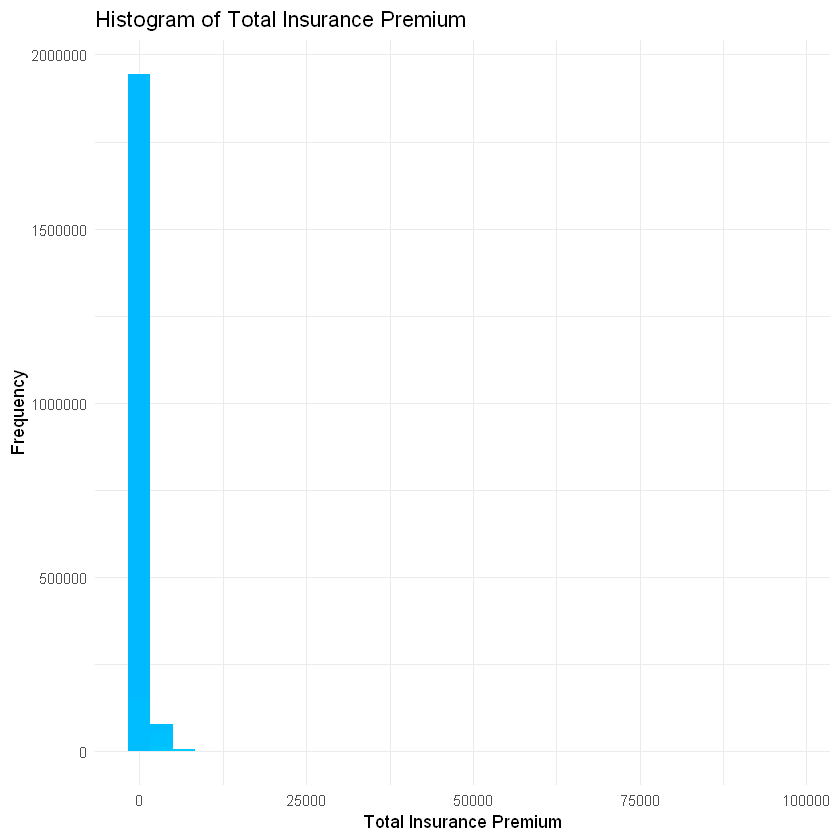

In [27]:
ggplot(df2, aes(x = totalinsurancepremiumofthepolicy, fill = cut(x=totalinsurancepremiumofthepolicy, 100))) +
  geom_histogram(show.legend = FALSE) +
  scale_fill_discrete(h = c(240, 10), c = 120, l = 70) +
  theme_minimal() +
  labs(x = "Total Insurance Premium", y = "Frequency") +
  ggtitle("Histogram of Total Insurance Premium")

dev.copy(jpeg,filename="Histogram of Total Insurance Premium_Original.jpg");
dev.off ()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   321.0   348.0   543.7   421.0 96900.0 

jpeg 
   3

png 
  2

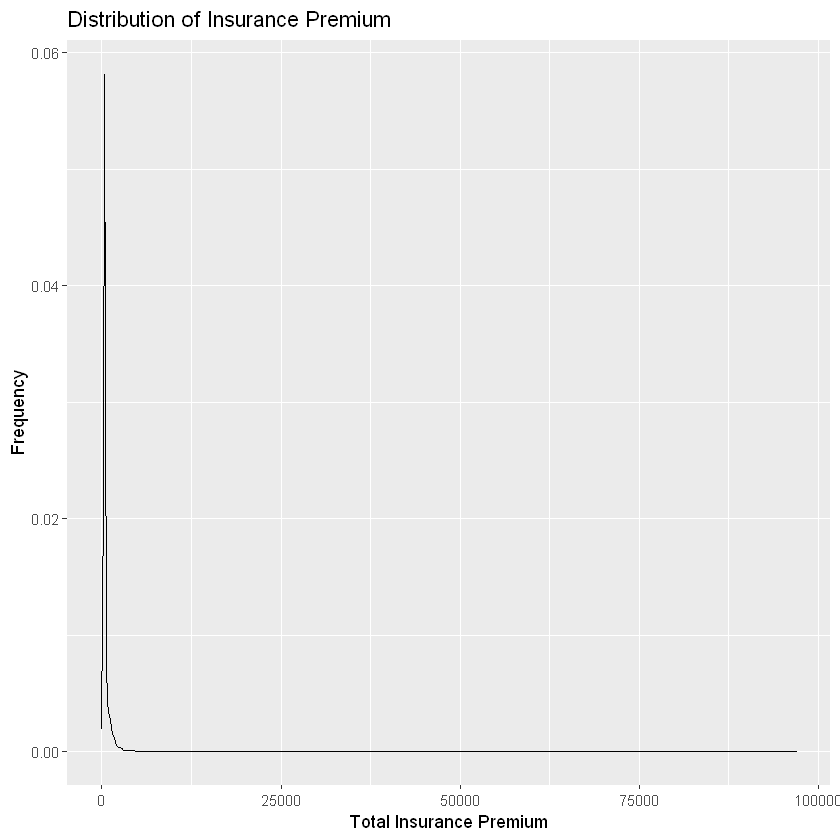

In [31]:
summary(df2$totalinsurancepremiumofthepolicy)
ggplot(data = df2, aes(x=totalinsurancepremiumofthepolicy)) + geom_density(alpha = 0.5)+
        labs(x = "Total Insurance Premium", y = "Frequency")+
                ggtitle("Distribution of Insurance Premium")

dev.copy(jpeg,filename="Distribution of Total Insurance Premium_Original.jpg");
dev.off ()

In [91]:
# As the number of totalinsurancepremiumofthepolicy > 3000 is only 0.1% then we remove all
# rows with the value higher than 5000 to eleminate error

df2 <- df2[(df2$totalinsurancepremiumofthepolicy < 3000),]
dfmode2 <- dfmode2[(dfmode2$totalinsurancepremiumofthepolicy < 3000),]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



jpeg 
   3

png 
  2

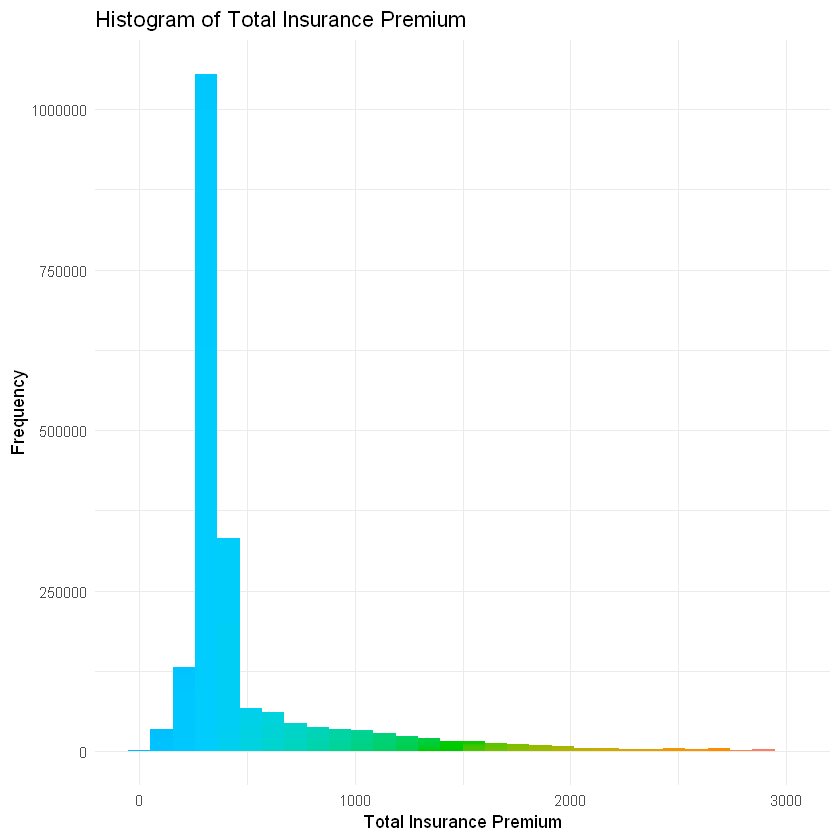

In [29]:
ggplot(df2, aes(x = totalinsurancepremiumofthepolicy, fill = cut(x=totalinsurancepremiumofthepolicy, 100))) +
  geom_histogram(show.legend = FALSE) +
  scale_fill_discrete(h = c(240, 10), c = 120, l = 70) +
  theme_minimal() +
  labs(x = "Total Insurance Premium", y = "Frequency") +
  ggtitle("Histogram of Total Insurance Premium")

dev.copy(jpeg,filename="Histogram of Total Insurance Premium_Final.jpg");
dev.off ()

jpeg 
   3

png 
  2

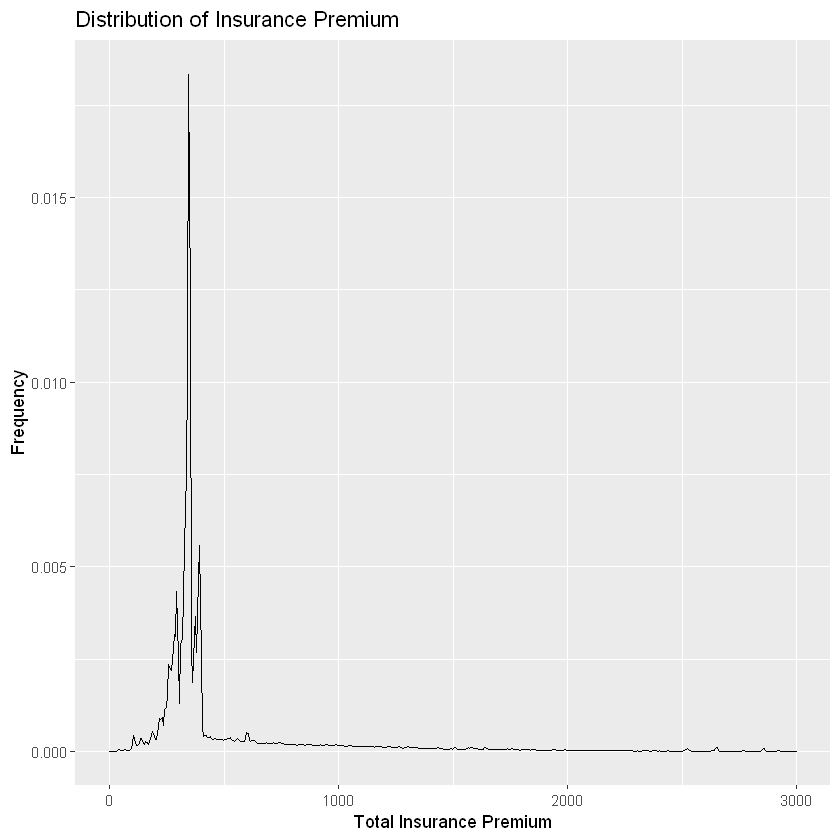

In [34]:
ggplot(data = df2, aes(x=totalinsurancepremiumofthepolicy)) + geom_density(alpha = 0.5)+
        labs(x = "Total Insurance Premium", y = "Frequency")+
                ggtitle("Distribution of Insurance Premium")

dev.copy(jpeg,filename="Distribution of Total Insurance Premium_Final.jpg");
dev.off ()

In [92]:
# Number of NA values in each column
colSums(is.na(df2))

basementenclosurecrawlspacetype                        censustract 
                                53                              14980 
                      construction                        crsdiscount 
                                 1                                  0 
deductibleamountinbuildingcoverage deductibleamountincontentscoverage 
                                 0                                  0 
         elevatedbuildingindicator                elevationdifference 
                                17                                  0 
                  federalpolicyfee                           latitude 
                                 0                              14980 
                         longitude    numberoffloorsininsuredbuilding 
                             14980                               7315 
                     occupancytype           originalconstructiondate 
                                 1                               7409 
                    originalnbdate                        policycount 
                                 0                                  0 
               policyeffectivedate              policyterminationdate 
                                 0                                  0 
               policytermindicator      postfirmconstructionindicator 
                                 0                               7409 
         primaryresidenceindicator                    reportedzipcode 
                              1481                                  0 
                        ratemethod     totalbuildinginsurancecoverage 
                             83930                                  0 
    totalcontentsinsurancecoverage   totalinsurancepremiumofthepolicy 
                                 0                                  0 
                         not_condo                            u_condo 
                                 1                                  1 
                    lowerflooronly                upperandlowerfloors 
                                 0                                  0 
                  basementandabove                       basementonly 
                                 0                                  0 
                    morethan1floor                mobilehomeortrailer 
                                 0                                  0 
                floodzone_highrisk                  floodzone_modrisk 
                              7307                               7307 
            floodzone_undetermined 
                              7307

In [93]:
# Exporting the dataframes to clean folder
imputingwith0 <- "../02_CleanData/policy_clean_0imputed.parquet"
imputingwithmode <- "../02_CleanData/policy_clean_modeimputed.parquet"
write_parquet(df2,imputingwith0)
write_parquet(dfmode2, imputingwithmode)

# 2-Feature Selection

In [94]:
rm(list = ls())

In [132]:
library(arrow) # needed to read parquet file
library(rpart)
library(plyr)
library(dplyr)
library(car)
library(caret)
library(rattle)
library(rpart.plot)
library(ggplot2)
library(corrplot)
library(tidyr)
library(elasticnet)

ERROR: Error in library(elasticnet): there is no package called 'elasticnet'


In [96]:
file_path <- "../02_CleanData/policy_clean_0imputed.parquet"
df <- read_parquet(file_path, as_tibble = TRUE)

In [97]:
str(df)

tibble [2,010,347 × 37] (S3: tbl_df/tbl/data.frame)
 $ basementenclosurecrawlspacetype   : num [1:2010347] 0 0 0 0 0 0 0 2 0 0 ...
 $ censustract                       : num [1:2010347] 4.82e+10 4.82e+10 4.82e+10 4.82e+10 4.82e+10 ...
 $ construction                      : num [1:2010347] 0 0 0 0 0 0 0 0 0 0 ...
 $ crsdiscount                       : num [1:2010347] 0 0.1 0.2 0 0 0 0 0.25 0 0 ...
 $ deductibleamountinbuildingcoverage: num [1:2010347] 1000 1000 1000 500 1000 1000 500 1000 500 500 ...
 $ deductibleamountincontentscoverage: num [1:2010347] 1000 1000 1000 500 1000 1000 500 500 500 500 ...
 $ elevatedbuildingindicator         : num [1:2010347] 0 0 0 0 0 0 0 1 0 0 ...
 $ elevationdifference               : num [1:2010347] 999 999 999 999 999 999 999 2 999 999 ...
 $ federalpolicyfee                  : num [1:2010347] 13 35 35 13 13 13 13 35 13 13 ...
 $ latitude                          : num [1:2010347] 29.6 30 29.8 29.8 29.8 29.6 29.8 29.8 30 29.8 ...
 $ longitude         

In [98]:
# more data cleaning
# ratemethod is categorical
df$ratemethod_manual <- ifelse( (df$ratemethod==1),1,0) # manual rate method; others are all grouped together as they follow a procedure
df$ratemethod_prp <- ifelse( (df$ratemethod==7),1,0) # preferred risk policy
df <- subset(df,select=-c(ratemethod)) # drop ratemethod after defining the dummy variable

# 999 in elevationdifference means na; also there are a few outlier:-9986, 9989 that must be typos
df$elevationdifference <- na_if(df$elevationdifference, 999)
df$elevationdifference <- na_if(df$elevationdifference, -9986)
df$elevationdifference <- na_if(df$elevationdifference, 9989)

# occupancy type to dummy
df$occupancytype_single <- ifelse( (df$occupancytype==1),1,0) # single family home
df$occupancytype_2or4 <- ifelse( (df$occupancytype==2),1,0) # 2-4 unit building
df$occupancytype_4more <- ifelse( (df$occupancytype==3 | df$occupancytype==4),1,0) # more than 4 unit building
df$occupancytype_business <- ifelse( (df$occupancytype==6),1,0) # non-residential business building
# drop occupancytype after defining the dummy variable
df <- subset(df, select=-c(occupancytype))

In [100]:
cols = colnames(df) # all columns
date_list = c() # list of date variables
for (c in cols){
  if (endsWith(c, 'date') == TRUE){
    date_list <- append(c, date_list)
  }
  
}
# num_list <- cols[!cols %in% date_list]
# ind_list = c() # indicator list
# for (c in num_list){
#   if (unique(df[c][is.na(df[c])==0]) == list(0,1)){
#     ind_list <- append(c, ind_list)
#   }
# }
# ind_list #list of indicator/dummy variables
# num_list2 <- num_list[!num_list %in% ind_list] #list of continuous variables
# num_list2

In [ ]:
# Select continuous variables for correlation examination

In [101]:
# Examine correlation between all numeric variables 
df_num <- subset(df, select = c(basementenclosurecrawlspacetype, censustract,crsdiscount,
                               deductibleamountinbuildingcoverage, deductibleamountincontentscoverage, 
                               federalpolicyfee, latitude, longitude, policycount, reportedzipcode, 
                               ratemethod_manual, ratemethod_prp, totalbuildinginsurancecoverage, 
                               totalcontentsinsurancecoverage))
cormat <-cor(df_num, use = "pairwise.complete.obs")

jpeg 
   3

png 
  2

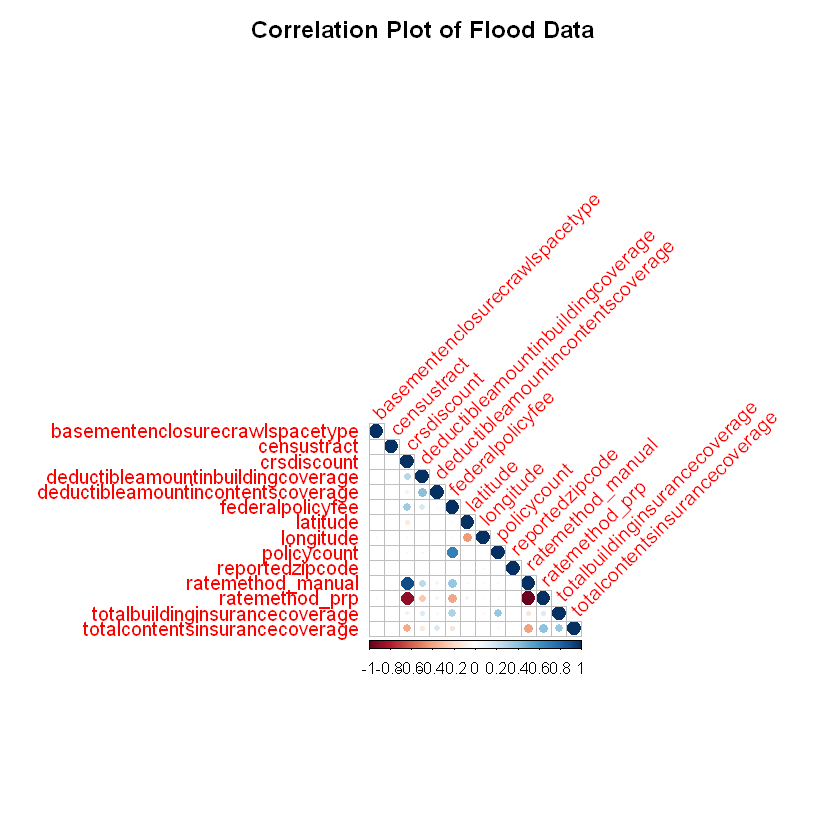

In [102]:
corrplot(cormat, tl.col = "red", tl.srt = 45, bg = "White",
         title = "\n\n Correlation Plot of Flood Data",
         type = "lower")
dev.copy(jpeg, filename="Correlation Plot of Flood Data.jpg");
dev.off ()

In [103]:
# Looking for Spearman correlation (checks nonlinear correlation too eg y=x3 has Spearman correlation of 1)
# computationally demanding
cormat_nonlin <- cor(df_num, use = "pairwise.complete.obs", method="spearman")
cormat_nonlin

,basementenclosurecrawlspacetype,censustract,crsdiscount,deductibleamountinbuildingcoverage,deductibleamountincontentscoverage,federalpolicyfee,latitude,longitude,policycount,reportedzipcode,ratemethod_manual,ratemethod_prp,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage
basementenclosurecrawlspacetype,1.000000000,-0.027903103,0.003664553,0.03844982,0.018544983,0.05342798,-0.0097650567,0.063371933,0.006226167,-0.095567932,-0.001193068,-0.05920036,0.0308794648,0.001478634
censustract,-0.027903103,1.000000000,-0.036406631,0.02214131,0.031417911,-0.01367685,0.5388037949,-0.693756148,-0.003398148,0.244708598,-0.032108849,0.03330565,0.1054462138,0.084694121
crsdiscount,0.003664553,-0.036406631,1.000000000,0.32517147,-0.093367544,0.64069855,-0.1016330718,-0.028817125,0.074550177,0.126874522,0.958515614,-0.95116315,-0.2332036325,-0.530895609
deductibleamountinbuildingcoverage,0.038449824,0.022141307,0.325171468,1.00000000,0.596367350,0.56183736,-0.0199614167,-0.039555962,0.038109980,0.044480457,0.262016587,-0.26621764,0.1830838891,-0.075492090
deductibleamountincontentscoverage,0.018544983,0.031417911,-0.093367544,0.59636735,1.000000000,0.27182594,0.0156090751,-0.009292532,-0.073592790,-0.009408480,-0.137235747,0.13763456,0.2059884364,0.360654968
federalpolicyfee,0.053427984,-0.013676849,0.640698549,0.56183736,0.271825942,1.00000000,-0.0463802434,-0.025163347,0.071858696,0.062749168,0.651016367,-0.65978468,-0.0854738073,-0.296553421
latitude,-0.009765057,0.538803795,-0.101633072,-0.01996142,0.015609075,-0.04638024,1.0000000000,-0.373135134,-0.019193158,0.009971773,-0.069095983,0.07166176,0.0009543902,0.031677224
longitude,0.063371933,-0.693756148,-0.028817125,-0.03955596,-0.009292532,-0.02516335,-0.3731351339,1.000000000,-0.011300911,-0.400900744,-0.018611358,0.01203623,-0.0730864512,-0.036794843
policycount,0.006226167,-0.003398148,0.074550177,0.03810998,-0.073592790,0.07185870,-0.0191931579,-0.011300911,1.000000000,-0.006012995,0.070761391,-0.07139681,0.0815729430,-0.080636180
reportedzipcode,-0.095567932,0.244708598,0.126874522,0.04448046,-0.009408480,0.06274917,0.0099717730,-0.400900744,-0.006012995,1.000000000,0.093551088,-0.08757457,-0.0725155015,-0.106441305


jpeg 
   3

png 
  2

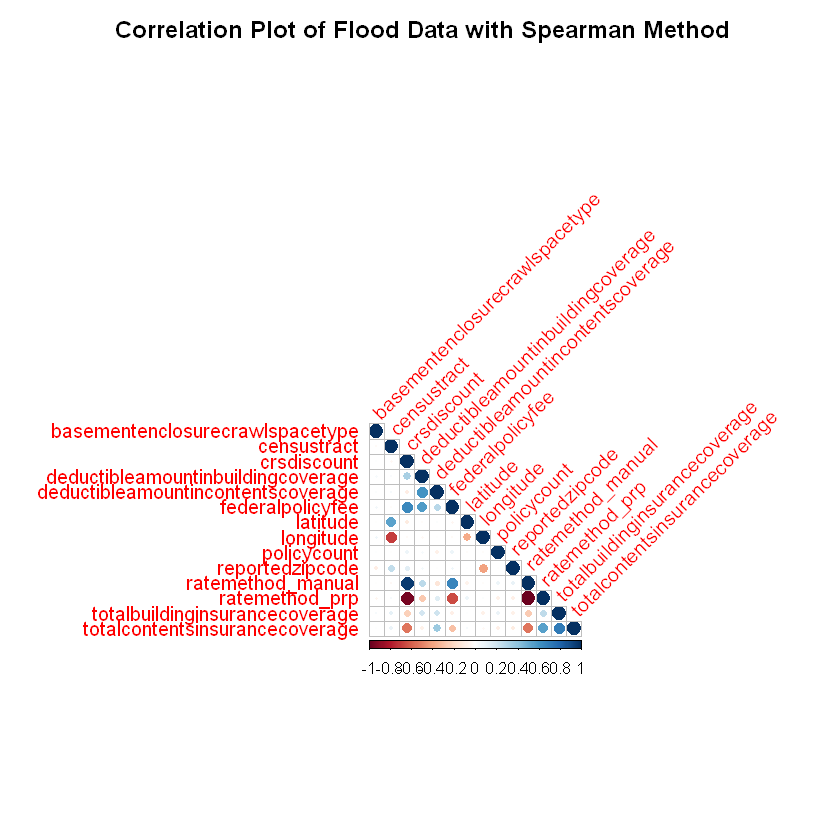

In [104]:
corrplot(cormat_nonlin, tl.col = "red", tl.srt = 45, bg = "White",
         title = "\n\n Correlation Plot of Flood Data with Spearman Method",
         type = "lower")

dev.copy(jpeg, filename="Correlation Plot of Flood Data using Spearman.jpg");
dev.off ()

In [105]:
## Remove Multicollinearity with cutoff 0.6
highly_corelated = findCorrelation(cormat_nonlin, cutoff = 0.6)
highlyCor_Col_nonlin = colnames(df_num)[highly_corelated]
highlyCor_Col_nonlin
# Now, we remove highly correlated variables from original dataset and create cleaner dataset, the dataset now contains 41 columns
df_clean = df[, -which(colnames(df) %in% highlyCor_Col_nonlin)]
dim(df_clean)

[1] "ratemethod_prp"                 "crsdiscount"                   
[3] "ratemethod_manual"              "totalcontentsinsurancecoverage"
[5] "censustract"

[1] 2010347      36

In [106]:
var_list <- colnames(df_clean)
var_list <- var_list[!var_list %in% date_list]
df_clean2 <- subset(df_clean, select=(var_list))

In [107]:
cor(subset(df_clean2, select=c(elevationdifference, totalinsurancepremiumofthepolicy)), 
    use = "pairwise.complete.obs", method="spearman")
# elevatiodifference has a high nonlinear correlation with the target variable (~-0.66) ==> 
#it should not be removed 

# replace na with mean and see if corrrelation holds
df_clean3 <- df_clean2
df_clean3$elevationdifference[is.na(df_clean3$elevationdifference)] <- mean(df_clean2$elevationdifference, na.rm=TRUE)
cor(subset(df_clean3, select=c(elevationdifference, totalinsurancepremiumofthepolicy)), 
    use = "pairwise.complete.obs", method="spearman")
# The correlation doesn't hold, but the direction holds (still negative) and the value is still high (-0.29)
# this works better than other forms of imputation, keeping it

,elevationdifference,totalinsurancepremiumofthepolicy
elevationdifference,1.0000000,-0.6586606
totalinsurancepremiumofthepolicy,-0.6586606,1.0000000


,elevationdifference,totalinsurancepremiumofthepolicy
elevationdifference,1.0000000,-0.2960271
totalinsurancepremiumofthepolicy,-0.2960271,1.0000000


In [108]:
colSums(is.na(df_clean3))

basementenclosurecrawlspacetype                       construction 
                                53                                  1 
deductibleamountinbuildingcoverage deductibleamountincontentscoverage 
                                 0                                  0 
         elevatedbuildingindicator                elevationdifference 
                                17                                  0 
                  federalpolicyfee                           latitude 
                                 0                              14980 
                         longitude    numberoffloorsininsuredbuilding 
                             14980                               7315 
                       policycount                policytermindicator 
                                 0                                  0 
     postfirmconstructionindicator          primaryresidenceindicator 
                              7409                               1481 
                   reportedzipcode     totalbuildinginsurancecoverage 
                                 0                                  0 
  totalinsurancepremiumofthepolicy                          not_condo 
                                 0                                  1 
                           u_condo                     lowerflooronly 
                                 1                                  0 
               upperandlowerfloors                   basementandabove 
                                 0                                  0 
                      basementonly                     morethan1floor 
                                 0                                  0 
               mobilehomeortrailer                 floodzone_highrisk 
                                 0                               7307 
                 floodzone_modrisk             floodzone_undetermined 
                              7307                               7307 
              occupancytype_single                 occupancytype_2or4 
                                 1                                  1 
               occupancytype_4more             occupancytype_business 
                                 1                                  1

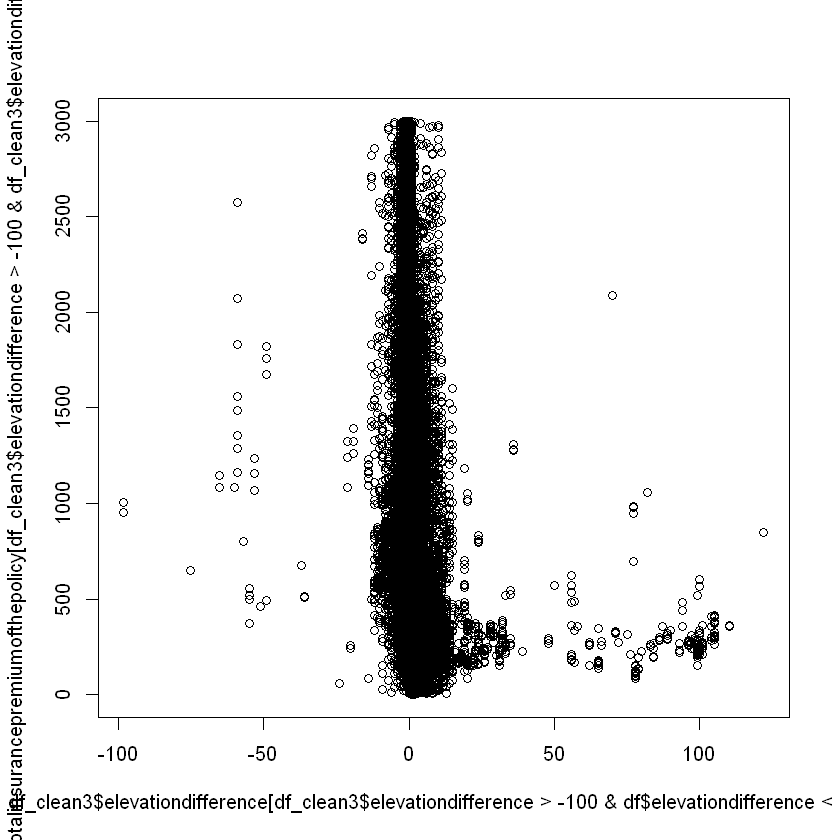

In [57]:
# plotting elevation differences between -100 to 250 (majority of data)
plot(df_clean3$elevationdifference[df_clean3$elevationdifference> -100 & df$elevationdifference<250], df_clean3$totalinsurancepremiumofthepolicy[df_clean3$elevationdifference> -100 & df_clean3$elevationdifference<250])

In [109]:
# reportedzipcode: 5 digit Postal Zip Code for the insured property reported by WYO partners
# It's not a real number; also we have longitude and latitude ==> need to omit it for modeling
# For now it is kept to be able to do filtering based on zipcode for later
#df_clean3 <- subset(df_clean3, select=-c(reportedzipcode))

# remove rows with na values
row.has.na <- apply(df_clean3, 1, function(x){any(is.na(x))})
sum(row.has.na) # number of NAs
df_clean3 <- df_clean3[!row.has.na,]
nrow(df_clean3) # number of rows after removing NAs

[1] 22461

[1] 1987886

In [110]:
# running the first linear regression
temp <- subset(df_clean3, select = -c(reportedzipcode))
fit = lm(totalinsurancepremiumofthepolicy ~., data=temp)
summary(fit)


Call:
lm(formula = totalinsurancepremiumofthepolicy ~ ., data = temp)

Residuals:
     Min       1Q   Median       3Q      Max 
-14351.5   -126.0    -51.5     24.0  11952.8 

Coefficients: (4 not defined because of singularities)
                                     Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                         2.194e+02  2.225e+02    0.986   0.3241    
basementenclosurecrawlspacetype     1.218e+01  8.278e-01   14.718  < 2e-16 ***
construction                       -2.344e+02  5.177e+00  -45.278  < 2e-16 ***
deductibleamountinbuildingcoverage -4.160e-03  1.431e-04  -29.064  < 2e-16 ***
deductibleamountincontentscoverage  3.346e-02  2.339e-04  143.029  < 2e-16 ***
elevatedbuildingindicator          -1.594e+02  1.555e+00 -102.460  < 2e-16 ***
elevationdifference                -7.238e+00  7.522e-02  -96.225  < 2e-16 ***
federalpolicyfee                    2.010e+00  1.418e-02  141.745  < 2e-16 ***
latitude                            4.801e+01  2.372e+00  

In [111]:
# removing variables with NA coefficients
# NA as a coefficient in a regression indicates that the variable in question is linearly related 
# to the other variables.
df_clean3 <- subset(df_clean3, select=-c(policytermindicator,mobilehomeortrailer, floodzone_undetermined, 
                                         occupancytype_business))
temp <- subset(df_clean3, select = -c(reportedzipcode))
fit = lm(totalinsurancepremiumofthepolicy ~., data=temp)
summary(fit)
# not removing insignificant features yet. Maybe after non-linear transformation they turn significant


Call:
lm(formula = totalinsurancepremiumofthepolicy ~ ., data = temp)

Residuals:
     Min       1Q   Median       3Q      Max 
-14351.5   -126.0    -51.5     24.0  11952.8 

Coefficients:
                                     Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                         2.194e+02  2.225e+02    0.986   0.3241    
basementenclosurecrawlspacetype     1.218e+01  8.278e-01   14.718  < 2e-16 ***
construction                       -2.344e+02  5.177e+00  -45.278  < 2e-16 ***
deductibleamountinbuildingcoverage -4.160e-03  1.431e-04  -29.064  < 2e-16 ***
deductibleamountincontentscoverage  3.346e-02  2.339e-04  143.029  < 2e-16 ***
elevatedbuildingindicator          -1.594e+02  1.555e+00 -102.460  < 2e-16 ***
elevationdifference                -7.238e+00  7.522e-02  -96.225  < 2e-16 ***
federalpolicyfee                    2.010e+00  1.418e-02  141.745  < 2e-16 ***
latitude                            4.801e+01  2.372e+00   20.237  < 2e-16 ***
longitude           

In [112]:
# check log-linear model
fit = lm(log(totalinsurancepremiumofthepolicy+1) ~ ., data=temp)
summary(fit)


Call:
lm(formula = log(totalinsurancepremiumofthepolicy + 1) ~ ., data = temp)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.7747  -0.1739  -0.0492   0.0775  18.3915 

Coefficients:
                                     Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                         4.029e+00  2.884e-01   13.968  < 2e-16 ***
basementenclosurecrawlspacetype     1.926e-02  1.073e-03   17.945  < 2e-16 ***
construction                       -3.965e-01  6.712e-03  -59.081  < 2e-16 ***
deductibleamountinbuildingcoverage -3.481e-06  1.856e-07  -18.761  < 2e-16 ***
deductibleamountincontentscoverage  3.970e-05  3.033e-07  130.926  < 2e-16 ***
elevatedbuildingindicator          -2.458e-01  2.017e-03 -121.888  < 2e-16 ***
elevationdifference                -1.160e-02  9.751e-05 -118.984  < 2e-16 ***
federalpolicyfee                    2.729e-03  1.838e-05  148.452  < 2e-16 ***
latitude                            4.701e-02  3.076e-03   15.285  < 2e-16 ***
longitude  

In [113]:
# there is a non-linear trend here.
# let's check if the features need to be transformed too
final_features = colnames(df_clean3)
final_features <- final_features[final_features != "totalinsurancepremiumofthepolicy" & final_features != "reportedzipcode"]
final_features

[1] "basementenclosurecrawlspacetype"    "construction"                      
 [3] "deductibleamountinbuildingcoverage" "deductibleamountincontentscoverage"
 [5] "elevatedbuildingindicator"          "elevationdifference"               
 [7] "federalpolicyfee"                   "latitude"                          
 [9] "longitude"                          "numberoffloorsininsuredbuilding"   
[11] "policycount"                        "postfirmconstructionindicator"     
[13] "primaryresidenceindicator"          "totalbuildinginsurancecoverage"    
[15] "not_condo"                          "u_condo"                           
[17] "lowerflooronly"                     "upperandlowerfloors"               
[19] "basementandabove"                   "basementonly"                      
[21] "morethan1floor"                     "floodzone_highrisk"                
[23] "floodzone_modrisk"                  "occupancytype_single"              
[25] "occupancytype_2or4"                 "occupancytype_4more"

In [114]:
# log transformation
# for each feature compare adjusted R2 for log transformation; it will print the features whose log transformation increases adjusted R2
mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ basementenclosurecrawlspacetype, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(basementenclosurecrawlspacetype+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("basementenclosurecrawlspacetype")
}

mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ construction, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(construction+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("construction")
}

mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ deductibleamountinbuildingcoverage, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(deductibleamountinbuildingcoverage+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("deductibleamountinbuildingcoverage")
}

mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ deductibleamountincontentscoverage, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(deductibleamountincontentscoverage+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("deductibleamountincontentscoverage")
}

mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ elevatedbuildingindicator, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(elevatedbuildingindicator+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("elevatedbuildingindicator")
}

const <- abs(min(df_clean3$elevationdifference))
mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ elevationdifference, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(elevationdifference+const+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("elevationdifference+const")
}

mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ federalpolicyfee, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(federalpolicyfee+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("federalpolicyfee")
}

const <- abs(min(df_clean3$latitude))
mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ latitude, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(latitude+const+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("latitude+const")
}


[1] "basementenclosurecrawlspacetype"
[1] "deductibleamountinbuildingcoverage"


In [115]:
# continue with log transformation of continuous features and comparing R2
const <- abs(min(df_clean3$longitude))
mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ longitude, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(longitude+const+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("longitude+const")
}

const <- abs(min(df_clean3$numberoffloorsininsuredbuilding))
mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ numberoffloorsininsuredbuilding, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(numberoffloorsininsuredbuilding+const+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("numberoffloorsininsuredbuilding")
}

#const <- abs(min(df_clean3$policycount))
mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ policycount, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(policycount+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("policycount")
}


mod_lin <- lm(log(totalinsurancepremiumofthepolicy+1) ~ totalbuildinginsurancecoverage, 
              data = df_clean3)
mod_log <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(totalbuildinginsurancecoverage+1), 
              data = df_clean3)
if (summary(mod_log)$adj.r.squared > summary(mod_lin)$adj.r.squared) {
  print("totalbuildinginsurancecoverage")
}

[1] "numberoffloorsininsuredbuilding"
[1] "policycount"


In [116]:
const <- abs(min(df_clean3$numberoffloorsininsuredbuilding))
# log transformation of indicator variables makes no difference on R2
fit <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(basementenclosurecrawlspacetype+1) + 
            construction +
            log(deductibleamountinbuildingcoverage+1) +
            deductibleamountincontentscoverage +
            elevatedbuildingindicator +
            elevationdifference +
            federalpolicyfee +
            latitude +
            longitude +
            log(numberoffloorsininsuredbuilding+const+1) +
            log(policycount+1) +
            postfirmconstructionindicator +
            primaryresidenceindicator +
            totalbuildinginsurancecoverage +
            not_condo +
            (u_condo) + 
            (lowerflooronly) + 
            (upperandlowerfloors) + 
            (basementandabove) + 
            basementonly +
            (morethan1floor) + # 
            (floodzone_highrisk) + 
            #floodzone_modrisk + # not significant
            occupancytype_single +
            occupancytype_2or4 +
            (occupancytype_4more), 
            data= df_clean3
            )
summary(fit)


Call:
lm(formula = log(totalinsurancepremiumofthepolicy + 1) ~ log(basementenclosurecrawlspacetype + 
    1) + construction + log(deductibleamountinbuildingcoverage + 
    1) + deductibleamountincontentscoverage + elevatedbuildingindicator + 
    elevationdifference + federalpolicyfee + latitude + longitude + 
    log(numberoffloorsininsuredbuilding + const + 1) + log(policycount + 
    1) + postfirmconstructionindicator + primaryresidenceindicator + 
    totalbuildinginsurancecoverage + not_condo + (u_condo) + 
    (lowerflooronly) + (upperandlowerfloors) + (basementandabove) + 
    basementonly + (morethan1floor) + (floodzone_highrisk) + 
    occupancytype_single + occupancytype_2or4 + (occupancytype_4more), 
    data = df_clean3)

Residuals:
     Min       1Q   Median       3Q      Max 
-24.5973  -0.1737  -0.0496   0.0738  11.0906 

Coefficients:
                                                   Estimate Std. Error  t value
(Intercept)                                       7.805e+

In [117]:
# try cubic root transformation

temp <- df_clean3
temp$elevationdifference_trans <- (temp$elevationdifference)^(1/3)
temp$deductibleamountinbuildingcoverage_trans <- (temp$deductibleamountinbuildingcoverage)^(1/3)
temp$deductibleamountincontentscoverage_trans <- (temp$deductibleamountincontentscoverage)^(1/3)
temp$basementenclosurecrawlspacetype_trans <- (temp$basementenclosurecrawlspacetype)^(1/3)
temp$totalbuildinginsurancecoverage_trans <- (temp$totalbuildinginsurancecoverage)^(1/3)
temp$latitude_trans <- (temp$latitude)^(1/3) # no difference
temp$longitude_trans <- (temp$longitude)^(1/3)
  
const <- abs(min(df_clean3$numberoffloorsininsuredbuilding))

# log transformation of indicator variables makes no difference on R2
fit <- lm(log(totalinsurancepremiumofthepolicy+1) ~ log(basementenclosurecrawlspacetype+1) + 
            construction +
            deductibleamountinbuildingcoverage_trans +
            deductibleamountincontentscoverage_trans +
            elevatedbuildingindicator +
            elevationdifference_trans +
            federalpolicyfee +
            latitude +
            longitude +
            log(numberoffloorsininsuredbuilding+const+1) +
            log(policycount+1) +
            postfirmconstructionindicator +
            primaryresidenceindicator +
            totalbuildinginsurancecoverage_trans +
            not_condo +
            (u_condo) + 
            (lowerflooronly) + 
            (upperandlowerfloors) + 
            (basementandabove) + 
            basementonly +
            (morethan1floor) + 
            (floodzone_highrisk) + 
            occupancytype_single +
            occupancytype_2or4 +
            (occupancytype_4more), 
            data= temp
            )
summary(fit)


Call:
lm(formula = log(totalinsurancepremiumofthepolicy + 1) ~ log(basementenclosurecrawlspacetype + 
    1) + construction + deductibleamountinbuildingcoverage_trans + 
    deductibleamountincontentscoverage_trans + elevatedbuildingindicator + 
    elevationdifference_trans + federalpolicyfee + latitude + 
    longitude + log(numberoffloorsininsuredbuilding + const + 
    1) + log(policycount + 1) + postfirmconstructionindicator + 
    primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    not_condo + (u_condo) + (lowerflooronly) + (upperandlowerfloors) + 
    (basementandabove) + basementonly + (morethan1floor) + (floodzone_highrisk) + 
    occupancytype_single + occupancytype_2or4 + (occupancytype_4more), 
    data = temp)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9751 -0.1795 -0.0534  0.0660  4.6935 

Coefficients:
                                                   Estimate Std. Error  t value
(Intercept)                                       9.567e+

In [118]:
# None are insignificant
# Choose a VIF cutoff under which a variable is retained (Zuur et al. 2010) 
# vif>10  multi-collinearity: remove variables with vif > 10
## Create the final dataset for further analysis
vif(fit)

log(basementenclosurecrawlspacetype + 1) 
                                        1.927428 
                                    construction 
                                        1.054082 
        deductibleamountinbuildingcoverage_trans 
                                        1.559294 
        deductibleamountincontentscoverage_trans 
                                        1.449160 
                       elevatedbuildingindicator 
                                        1.303702 
                       elevationdifference_trans 
                                        1.083915 
                                federalpolicyfee 
                                        2.840896 
                                        latitude 
                                        1.270690 
                                       longitude 
                                        1.259660 
log(numberoffloorsininsuredbuilding + const + 1) 
                                        3.514129 
                            log(policycount + 1) 
                                       13.623374 
                   postfirmconstructionindicator 
                                        1.190835 
                       primaryresidenceindicator 
                                        1.568964 
            totalbuildinginsurancecoverage_trans 
                                        1.397842 
                                       not_condo 
                                       89.778978 
                                         u_condo 
                                       80.788145 
                                  lowerflooronly 
                                        3.301255 
                             upperandlowerfloors 
                                        3.112561 
                                basementandabove 
                                        1.938208 
                                    basementonly 
                                        1.000501 
                                  morethan1floor 
                                        1.045264 
                              floodzone_highrisk 
                                        1.659957 
                            occupancytype_single 
                                        7.078684 
                              occupancytype_2or4 
                                        1.809080 
                             occupancytype_4more 
                                        5.857502

In [119]:
df_final <- subset(temp, select = -c(not_condo, policycount, u_condo))

const <- abs(min(df_final$numberoffloorsininsuredbuilding))

df_final$totalinsurancepremiumofthepolicy_log <- log(df_final$totalinsurancepremiumofthepolicy+1)
df_final$basementenclosurecrawlspacetype_log <- log(df_final$basementenclosurecrawlspacetype +1)
df_final$numberoffloorsininsuredbuilding_log <- log(df_final$numberoffloorsininsuredbuilding+const+1)

df_final <- subset(df_final, select = c(totalinsurancepremiumofthepolicy_log,
                  #basementenclosurecrawlspacetype_log, 
                  construction, 
                  deductibleamountinbuildingcoverage_trans,
                  deductibleamountincontentscoverage_trans, 
                  elevatedbuildingindicator, 
                  elevationdifference_trans,
                  federalpolicyfee,
                  latitude,
                  longitude,
                  numberoffloorsininsuredbuilding_log,
                  postfirmconstructionindicator, 
                  primaryresidenceindicator, 
                  totalbuildinginsurancecoverage_trans,
                  lowerflooronly, 
                  upperandlowerfloors,
                  basementandabove,
                  basementonly,
                  morethan1floor,
                  floodzone_highrisk,
                  occupancytype_single,
                  occupancytype_2or4,
                  occupancytype_4more,
                  reportedzipcode)) #added for later filtering
temp0 <- subset(df_final, select = -c(reportedzipcode))
fit2 <- lm(totalinsurancepremiumofthepolicy_log~., data=temp0)
summary(fit2)


Call:
lm(formula = totalinsurancepremiumofthepolicy_log ~ ., data = temp0)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7552 -0.1801 -0.0555  0.0626  4.7847 

Coefficients:
                                           Estimate Std. Error  t value
(Intercept)                               7.239e+00  1.813e-01   39.932
construction                             -2.627e-01  6.616e-03  -39.713
deductibleamountinbuildingcoverage_trans -8.079e-04  1.502e-04   -5.379
deductibleamountincontentscoverage_trans  2.393e-02  1.224e-04  195.462
elevatedbuildingindicator                -1.846e-01  1.925e-03  -95.909
elevationdifference_trans                -4.691e-01  1.217e-03 -385.369
federalpolicyfee                          1.899e-03  1.203e-05  157.827
latitude                                  4.649e-02  2.918e-03   15.931
longitude                                 1.734e-02  2.105e-03    8.241
numberoffloorsininsuredbuilding_log      -4.474e-01  3.301e-03 -135.521
postfirmconstructionind

In [120]:
# Exporting the dataframe to EDA folder

# df_final_NoNA includes numeric (df_num) and 2 "date" columns

file_path3 <- "../03_EDA/df_final_0impute_nonlin.parquet"
write_parquet(df_final, file_path3)

In [122]:
# filter for top 5 zipcodes to manage data size so we can run random forest
names(which.max(table(df_final$reportedzipcode))) # "77096"

temp <- df_final %>% 
  filter(reportedzipcode != "77096")
names(which.max(table(temp$reportedzipcode))) # 77089
temp <- temp %>% 
  filter(reportedzipcode != "77089")
names(which.max(table(temp$reportedzipcode))) # 77084


temp <- temp %>% 
  filter(reportedzipcode != "77084")
names(which.max(table(temp$reportedzipcode))) # 77024

temp <- temp %>% 
  filter(reportedzipcode != "77024")
names(which.max(table(temp$reportedzipcode))) # 77062

df_5_Zipcode <- subset(df_final, reportedzipcode == '77096'| reportedzipcode == '77089' |reportedzipcode == '77084'| reportedzipcode == '77024' |reportedzipcode == '77062')

# Remove zipcode, the dataset includes 300K rows
#df_5_Zipcode <- subset(df_5_Zipcode, select=-c(reportedzipcode))
# remove rows with na values
row.has.na <- apply(df_5_Zipcode, 1, function(x){any(is.na(x))})
sum(row.has.na)

df_5_Zipcode <- df_5_Zipcode[!row.has.na,]
nrow(df_5_Zipcode)

file_path4 <- "../03_EDA/df_final_0impute_5zipcode.parquet"
write_parquet(df_5_Zipcode, file_path4)

[1] "77096"

[1] "77089"

[1] "77084"

[1] "77024"

[1] "77062"

[1] 2798

[1] 293794

In [123]:
# Import data again to avoid run all above commands
file_path <- "../03_EDA/df_final_0impute_nonlin.parquet"
df_num <- read_parquet(file_path, as_tibble = TRUE)

In [124]:
# Rerun lm to check significant variables
temp0 = subset(df_num, select=-c(reportedzipcode))
fit3 = lm(totalinsurancepremiumofthepolicy_log ~., temp0)
summary(fit3)


Call:
lm(formula = totalinsurancepremiumofthepolicy_log ~ ., data = temp0)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7552 -0.1801 -0.0555  0.0626  4.7847 

Coefficients:
                                           Estimate Std. Error  t value
(Intercept)                               7.239e+00  1.813e-01   39.932
construction                             -2.627e-01  6.616e-03  -39.713
deductibleamountinbuildingcoverage_trans -8.079e-04  1.502e-04   -5.379
deductibleamountincontentscoverage_trans  2.393e-02  1.224e-04  195.462
elevatedbuildingindicator                -1.846e-01  1.925e-03  -95.909
elevationdifference_trans                -4.691e-01  1.217e-03 -385.369
federalpolicyfee                          1.899e-03  1.203e-05  157.827
latitude                                  4.649e-02  2.918e-03   15.931
longitude                                 1.734e-02  2.105e-03    8.241
numberoffloorsininsuredbuilding_log      -4.474e-01  3.301e-03 -135.521
postfirmconstructionind

In [125]:
temp0 = subset(df_num, select=-c(reportedzipcode))
fit3 = lm(totalinsurancepremiumofthepolicy_log ~., temp0)
summary(fit3)


Call:
lm(formula = totalinsurancepremiumofthepolicy_log ~ ., data = temp0)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7552 -0.1801 -0.0555  0.0626  4.7847 

Coefficients:
                                           Estimate Std. Error  t value
(Intercept)                               7.239e+00  1.813e-01   39.932
construction                             -2.627e-01  6.616e-03  -39.713
deductibleamountinbuildingcoverage_trans -8.079e-04  1.502e-04   -5.379
deductibleamountincontentscoverage_trans  2.393e-02  1.224e-04  195.462
elevatedbuildingindicator                -1.846e-01  1.925e-03  -95.909
elevationdifference_trans                -4.691e-01  1.217e-03 -385.369
federalpolicyfee                          1.899e-03  1.203e-05  157.827
latitude                                  4.649e-02  2.918e-03   15.931
longitude                                 1.734e-02  2.105e-03    8.241
numberoffloorsininsuredbuilding_log      -4.474e-01  3.301e-03 -135.521
postfirmconstructionind

In [128]:
# 1. Stepwise regression

temp0 <- subset(df_num, select=-c(reportedzipcode))
# remove rows with na values
row.has.na <- apply(temp0, 1, function(x){any(is.na(x))})
sum(row.has.na)
temp0 <- temp0[!row.has.na,]
colnames(temp0)

[1] 20670

[1] "totalinsurancepremiumofthepolicy_log"    
 [2] "construction"                            
 [3] "deductibleamountinbuildingcoverage_trans"
 [4] "deductibleamountincontentscoverage_trans"
 [5] "elevatedbuildingindicator"               
 [6] "elevationdifference_trans"               
 [7] "federalpolicyfee"                        
 [8] "latitude"                                
 [9] "longitude"                               
[10] "numberoffloorsininsuredbuilding_log"     
[11] "postfirmconstructionindicator"           
[12] "primaryresidenceindicator"               
[13] "totalbuildinginsurancecoverage_trans"    
[14] "lowerflooronly"                          
[15] "upperandlowerfloors"                     
[16] "basementandabove"                        
[17] "basementonly"                            
[18] "morethan1floor"                          
[19] "floodzone_highrisk"                      
[20] "occupancytype_single"                    
[21] "occupancytype_2or4"                      
[22] "occupancytype_4more"

In [129]:
#computationally demanding
ctrl <- trainControl(method = "repeatedcv", number = 5, repeats = 2)

lmFit_Step <- train(totalinsurancepremiumofthepolicy_log ~ ., data = temp0, "lmStepAIC", scope = 
                 list(lower = totalinsurancepremiumofthepolicy_log~1, upper = totalinsurancepremiumofthepolicy_log~.), direction = "backward",trControl=ctrl, na.action=na.exclude)


Start:  AIC=-2818117
.outcome ~ construction + deductibleamountinbuildingcoverage_trans + 
    deductibleamountincontentscoverage_trans + elevatedbuildingindicator + 
    elevationdifference_trans + federalpolicyfee + latitude + 
    longitude + numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    lowerflooronly + upperandlowerfloors + basementandabove + 
    basementonly + morethan1floor + floodzone_highrisk + occupancytype_single + 
    occupancytype_2or4 + occupancytype_4more

                                           Df Sum of Sq    RSS      AIC
<none>                                                  262572 -2818117
- basementonly                              1         2 262574 -2818104
- deductibleamountinbuildingcoverage_trans  1         5 262576 -2818091
- longitude                                 1         8 262580 -2818070
- latitude                                  1        33 26260

Start:  AIC=-2818987
.outcome ~ construction + deductibleamountinbuildingcoverage_trans + 
    deductibleamountincontentscoverage_trans + elevatedbuildingindicator + 
    elevationdifference_trans + federalpolicyfee + latitude + 
    longitude + numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    lowerflooronly + upperandlowerfloors + basementandabove + 
    basementonly + morethan1floor + floodzone_highrisk + occupancytype_single + 
    occupancytype_2or4 + occupancytype_4more

                                           Df Sum of Sq    RSS      AIC
<none>                                                  262427 -2818987
- basementonly                              1         1 262428 -2818985
- deductibleamountinbuildingcoverage_trans  1         4 262431 -2818962
- longitude                                 1         8 262435 -2818940
- latitude                                  1        34 26246

Start:  AIC=-2820573
.outcome ~ construction + deductibleamountinbuildingcoverage_trans + 
    deductibleamountincontentscoverage_trans + elevatedbuildingindicator + 
    elevationdifference_trans + federalpolicyfee + latitude + 
    longitude + numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    lowerflooronly + upperandlowerfloors + basementandabove + 
    basementonly + morethan1floor + floodzone_highrisk + occupancytype_single + 
    occupancytype_2or4 + occupancytype_4more

                                           Df Sum of Sq    RSS      AIC
<none>                                                  262163 -2820573
- basementonly                              1         1 262164 -2820571
- deductibleamountinbuildingcoverage_trans  1         3 262166 -2820557
- longitude                                 1         9 262172 -2820520
- latitude                                  1        33 26219

In [ ]:
# the lowest AIC (-3523771) keeps all the features

In [130]:
mod_Step = lm(totalinsurancepremiumofthepolicy_log ~ construction + deductibleamountinbuildingcoverage_trans + 
    deductibleamountincontentscoverage_trans + elevatedbuildingindicator + 
    elevationdifference_trans + federalpolicyfee + latitude + 
    longitude + numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    lowerflooronly + upperandlowerfloors + basementandabove + 
    basementonly + morethan1floor + floodzone_highrisk + occupancytype_single + 
    occupancytype_2or4 + occupancytype_4more,
    data = temp0)
summary(mod_Step)


Call:
lm(formula = totalinsurancepremiumofthepolicy_log ~ construction + 
    deductibleamountinbuildingcoverage_trans + deductibleamountincontentscoverage_trans + 
    elevatedbuildingindicator + elevationdifference_trans + federalpolicyfee + 
    latitude + longitude + numberoffloorsininsuredbuilding_log + 
    postfirmconstructionindicator + primaryresidenceindicator + 
    totalbuildinginsurancecoverage_trans + lowerflooronly + upperandlowerfloors + 
    basementandabove + basementonly + morethan1floor + floodzone_highrisk + 
    occupancytype_single + occupancytype_2or4 + occupancytype_4more, 
    data = temp0)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7552 -0.1801 -0.0555  0.0626  4.7847 

Coefficients:
                                           Estimate Std. Error  t value
(Intercept)                               7.239e+00  1.813e-01   39.932
construction                             -2.627e-01  6.616e-03  -39.713
deductibleamountinbuildingcoverage_trans -8.079e-0

In [134]:
## LASSO
# computationally demanding
## Variable selections using Lasso

train_con <- trainControl(method = 'cv', number = 5) # using 5 folds cv

lasso <- train(totalinsurancepremiumofthepolicy_log ~., temp0,
               method = 'lasso',
               preProc = c('scale', 'center'),
               trControl = train_con
              )
summary(lasso)

            Length Class      Mode     
call          4    -none-     call     
actions      24    -none-     list     
allset       21    -none-     numeric  
beta.pure   504    -none-     numeric  
vn           21    -none-     character
mu            1    -none-     numeric  
normx        21    -none-     numeric  
meanx        21    -none-     numeric  
lambda        1    -none-     numeric  
L1norm       24    -none-     numeric  
penalty      24    -none-     numeric  
df           24    -none-     numeric  
Cp           24    -none-     numeric  
sigma2        1    -none-     numeric  
xNames       21    -none-     character
problemType   1    -none-     character
tuneValue     1    data.frame list     
obsLevels     1    -none-     logical  
param         0    -none-     list     

In [135]:
# Get coef

predict(lasso$finalModel, type = "coef", mode = "fraction", s = as.numeric(lasso$bestTune))

# We can further discard variables with coefficients reduced to zero

$s
[1] 0.9

$fraction
  0 
0.9 

$mode
[1] "fraction"

$coefficients
                            construction 
                            -0.010706161 
deductibleamountinbuildingcoverage_trans 
                             0.000000000 
deductibleamountincontentscoverage_trans 
                             0.064368657 
               elevatedbuildingindicator 
                            -0.028243948 
               elevationdifference_trans 
                            -0.114891579 
                        federalpolicyfee 
                             0.047924766 
                                latitude 
                             0.001501053 
                               longitude 
                             0.000000000 
     numberoffloorsininsuredbuilding_log 
                            -0.060889686 
           postfirmconstructionindicator 
                            -0.059532230 
               primaryresidenceindicator 
                            -0.028593210 
    totalbuildinginsurancecoverage_trans 
                             0.178900675 
                          lowerflooronly 
                            -0.025306622 
                     upperandlowerfloors 
                             0.001620847 
                        basementandabove 
                             0.007937619 
                            basementonly 
                             0.000000000 
                          morethan1floor 
                            -0.011403979 
                      floodzone_highrisk 
                             0.188972657 
                    occupancytype_single 
                            -0.235464994 
                      occupancytype_2or4 
                            -0.081657345 
                     occupancytype_4more 
                            -0.101583691

In [136]:
# From the Lasso Regression models, we can discard the variables with coefficients decreasing to zero, in this case we will remove variable "basementonly", and "longitude"

temp1 = subset(temp0,select=-c(basementonly, deductibleamountinbuildingcoverage_trans, longitude)) 

# Exporting the dataframe to Modeling folder
# df_num includes only numeric variables for analysis
file_path0 <- "../04_Modeling/df_num_impute0_Final_FeatureSel.parquet"
write_parquet(temp1, file_path0)

fit3 = lm(totalinsurancepremiumofthepolicy_log ~ construction + 
    deductibleamountincontentscoverage_trans + elevatedbuildingindicator + 
    elevationdifference_trans + federalpolicyfee + latitude + 
    numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    lowerflooronly + upperandlowerfloors + basementandabove + 
    morethan1floor + floodzone_highrisk + occupancytype_single + 
    occupancytype_2or4 + occupancytype_4more,
    data = temp1)
summary(fit3)


Call:
lm(formula = totalinsurancepremiumofthepolicy_log ~ construction + 
    deductibleamountincontentscoverage_trans + elevatedbuildingindicator + 
    elevationdifference_trans + federalpolicyfee + latitude + 
    numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    lowerflooronly + upperandlowerfloors + basementandabove + 
    morethan1floor + floodzone_highrisk + occupancytype_single + 
    occupancytype_2or4 + occupancytype_4more, data = temp1)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7601 -0.1801 -0.0550  0.0623  4.7798 

Coefficients:
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                               5.892e+00  7.861e-02   74.95   <2e-16
construction                             -2.637e-01  6.613e-03  -39.88   <2e-16
deductibleamountincontentscoverage_trans  2.379e-02  1.196e-04  198.86   <2e-16
elevatedbuildingindic

# 3-Modeling

## PCA

In [137]:
rm(list = ls())

In [156]:
# install.packages("tidyverse")
# install.packages("rsample")
# install.packages("randomForest")
# install.packages("janitor")
# install.packages("glmnet")
# install.packages("tree")
# install.packages("RColorBrewer")
# install.packages("stats")
# install.packages("DAAG")
# install.packages("GGally")
# install.packages("devtools")
# install.packages("ggbiplot")

Installing package into 'C:/Users/mjafarpour/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

Warning message:
"package 'ggbiplot' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"


In [155]:
library(arrow) # needed to read parquet file

library(dplyr)
library(car)
library(caret)
library(ggplot2)
library(corrplot)
library(tidyverse)
library(rsample)
library(randomForest)
library(janitor)
library(glmnet)
library(tree)
library(RColorBrewer)
library(gridExtra)

library(stats)  # for prcomp()
library(DAAG)
library(GGally)
library(devtools)
require(ggbiplot)

Loading required package: ggbiplot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'ggbiplot'"


In [157]:
file_path <- "../03_EDA/df_final_0impute_5zipcode.parquet"
df1 <- read_parquet(file_path, as_tibble = TRUE)

In [158]:
## Scale all numerical variables, remove reportedzipcode as we concetrated in 5 top zipcode and thus zipcode is not in need anymore. The dataset includes 293,794 rows of 23 variables and response. Noted that the  target variable is now called totalinsurancepremiumofthepolicy_log_log, as it is the log transformation of the actual variable from previous step.   
df = scale(as.data.frame(df1[,c(2,4,5,7,8,9,10,11,14)])) # standardize all numerical variables

df <- cbind(df1[,c(3,6,12,13,15,16,17,19, 20,21,22,23)],df,df1[,1]) # Add categorical columns  back in


In [159]:
PCA <- prcomp(df[,1:21])  # apply PCA

summary(PCA)

Importance of components:
                          PC1     PC2     PC3    PC4     PC5     PC6     PC7
Standard deviation     26.068 10.4115 2.10142 1.4153 1.31736 1.09450 1.03515
Proportion of Variance  0.848  0.1353 0.00551 0.0025 0.00217 0.00149 0.00134
Cumulative Proportion   0.848  0.9833 0.98880 0.9913 0.99346 0.99496 0.99630
                          PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.9379 0.87129 0.83676 0.45862 0.32927 0.31752 0.23981
Proportion of Variance 0.0011 0.00095 0.00087 0.00026 0.00014 0.00013 0.00007
Cumulative Proportion  0.9974 0.99834 0.99921 0.99948 0.99961 0.99974 0.99981
                          PC15    PC16    PC17    PC18    PC19    PC20
Standard deviation     0.22982 0.22627 0.19094 0.08190 0.05901 0.03734
Proportion of Variance 0.00007 0.00006 0.00005 0.00001 0.00000 0.00000
Cumulative Proportion  0.99988 0.99994 0.99999 0.99999 1.00000 1.00000
                            PC21
Standard deviation     4.616e-17
Prop

In [161]:
# # Common function to display PCA related plots in 2x2 grid
# screeplot(PCA, type='l')
# dev.copy(jpeg, filename="PCA_ScreePlot.jpg")
# dev.off ()

# bplot = ggbiplot(PCA,
#                  choices = c(1,2),
#                  obs.scale =1, var.scale =1,
#                  circle = TRUE,
#                  ellipse = TRUE,
#                  ellipse.prob = 0.68)

# print(bplot)

# dev.copy(jpeg, filename="PCA_Plot.jpg")
# dev.off ()

In [162]:
PCA_7 <- cbind(df[,22], PCA$x[,1:7])
modelPCA <- lm(V1~.,data = as.data.frame(PCA_7)) # fit model
summary(modelPCA) 

#cross_valPCA <- cv.lm(as.data.frame(PCA_7), modelPCA, m = 5) # cross-validate 

#R2_PCA <- 1 - attr(cross_valPCA,"ms")*nrow(df)/sum((df$totalinsurancepremiumofthepolicy_log - #mean(df$totalinsurancepremiumofthepolicy_log))^2) # calculate R-squared

#R2_PCA  #0.392


Call:
lm(formula = V1 ~ ., data = as.data.frame(PCA_7))

Residuals:
    Min      1Q  Median      3Q     Max 
-5.8902 -0.2630 -0.1137  0.1000  3.6161 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  6.072e+00  8.645e-04 7023.538  < 2e-16 ***
PC1          5.617e-03  3.316e-05  169.392  < 2e-16 ***
PC2         -1.593e-02  8.303e-05 -191.905  < 2e-16 ***
PC3         -8.291e-02  4.114e-04 -201.540  < 2e-16 ***
PC4          4.044e-03  6.108e-04    6.622 3.56e-11 ***
PC5         -4.053e-02  6.562e-04  -61.768  < 2e-16 ***
PC6         -2.985e-02  7.898e-04  -37.791  < 2e-16 ***
PC7         -1.497e-01  8.351e-04 -179.273  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4686 on 293786 degrees of freedom
Multiple R-squared:  0.3283,	Adjusted R-squared:  0.3282 
F-statistic: 2.051e+04 on 7 and 293786 DF,  p-value: < 2.2e-16


In [163]:
PCA_10 <- cbind(df[,22], PCA$x[,1:10])
modelPCA <- lm(V1~.,data = as.data.frame(PCA_10)) # fit model
summary(modelPCA) 
#cross_valPCA <- cv.lm(as.data.frame(PCA_10), modelPCA, m = 5) # cross-validate 

#R2_PCA <- 1 - attr(cross_valPCA,"ms")*nrow(df)/sum((df$totalinsurancepremiumofthepolicy_log - #mean(df$totalinsurancepremiumofthepolicy_log))^2) # calculate R-squared

#R2_PCA  #0.467


Call:
lm(formula = V1 ~ ., data = as.data.frame(PCA_10))

Residuals:
     Min       1Q   Median       3Q      Max 
-11.7585  -0.2406  -0.0933   0.1153   3.3324 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  6.072e+00  8.130e-04 7468.544  < 2e-16 ***
PC1          5.617e-03  3.119e-05  180.124  < 2e-16 ***
PC2         -1.593e-02  7.808e-05 -204.064  < 2e-16 ***
PC3         -8.291e-02  3.869e-04 -214.310  < 2e-16 ***
PC4          4.044e-03  5.744e-04    7.041 1.91e-12 ***
PC5         -4.053e-02  6.171e-04  -65.681  < 2e-16 ***
PC6         -2.985e-02  7.428e-04  -40.185  < 2e-16 ***
PC7         -1.497e-01  7.853e-04 -190.631  < 2e-16 ***
PC8          1.283e-01  8.668e-04  148.022  < 2e-16 ***
PC9         -1.704e-03  9.331e-04   -1.827   0.0677 .  
PC10         1.248e-01  9.715e-04  128.439  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4406 on 293783 degrees of freedom
Multiple R-squared:  0

In [164]:
PCA <- as.data.frame(PCA_10)
colnames(PCA)[1] <- "totalinsurancepremiumofthepolicy_log"
head(PCA)

,totalinsurancepremiumofthepolicy_log,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.817111,-10.33979,-4.889897,1.270961,1.0547073,1.39137520,0.33572850,1.04449700,-0.5223318,0.4124089,0.10017932
2,5.817111,-48.35978,-2.935693,2.160126,-0.9176923,0.00399991,-0.09962387,-1.12595396,0.2517322,-0.8300730,-0.65254218
3,5.817111,16.64068,-6.163392,1.581194,1.8409918,0.10279022,-0.12105107,-0.06810849,-0.1062827,-0.6402441,-0.76256684
4,5.817111,-48.35847,-2.937304,2.334808,-1.4686650,0.28115858,0.21450682,-0.04766255,-0.4466646,0.3211914,0.01793705
5,6.850126,23.67831,-6.706080,-1.317635,0.5636787,-1.02374863,-0.23825854,-0.70871742,0.1758697,-0.2040584,-0.08646458
6,5.749393,11.75665,-1.300237,3.116026,-3.1012847,-0.30338553,0.61051617,0.09055114,-0.3497660,-0.2953193,-0.38822715


In [165]:
file_path <- "../04_Modeling/PCA_10_data.parquet"
write_parquet(PCA, file_path)

In [166]:
# Now we will test few models with  PCA of 10 components

# Splitting data to 70% training, 30% testing of the data from PCA_10

set.seed(100)

size <- floor(0.7*nrow(PCA))
train_ind <- sample(seq_len(nrow(PCA)), size = size)

train <- PCA[train_ind, ]
test <- PCA[-train_ind, ]

In [167]:
xtrain = model.matrix(totalinsurancepremiumofthepolicy_log ~., train)[,-1]
ytrain = train$totalinsurancepremiumofthepolicy_log
xtest = model.matrix(totalinsurancepremiumofthepolicy_log ~., test)[,-1]
ytest = test$totalinsurancepremiumofthepolicy_log

In [170]:
# Function to calculate R square 
R_2 <- function(pred){
  
  r2 = 1 - (sum((test$totalinsurancepremiumofthepolicy_log - pred)^2)/sum((test$totalinsurancepremiumofthepolicy_log - mean(test$totalinsurancepremiumofthepolicy_log))^2))
  return (r2)
}

In [173]:
# 1. Lasso with PCA_10 components

cv.lasso.out = cv.glmnet(xtrain, ytrain, family = "gaussian", alpha = 1, nfolds = 5, type.measure = "mse")
bestlam.lasso = cv.lasso.out$lambda.min
i <- which(cv.lasso.out$lambda == cv.lasso.out$lambda.min)
mse.min.lasso <- cv.lasso.out$cvm[i]

lasso.model = glmnet(xtrain, ytrain, alpha=1, lambda=bestlam.lasso)

lasso.pred.train = predict(lasso.model, newx=xtrain)

R2.lasso.train = R_2(lasso.pred.train)
R2.lasso.train 

lasso.pred.test = predict(lasso.model, newx=xtest)

R2.lasso.test = R_2(lasso.pred.test)
R2.lasso.test

# print(paste('R_squared of test data in Lasso from 10 Principle components is', r2.lasso.test))

Warning message in test$totalinsurancepremiumofthepolicy_log - pred:
"longer object length is not a multiple of shorter object length"


[1] -2.269043

[1] 0.4011242

### Nonlinear Models

In [174]:
# Remove previous data from environment
rm(list = ls())

In [176]:
if (!require("sjPlot")) install.packages("sjPlot")
if (!require("tidyverse")) install.packages("sjPlot")
if (!require("pls")) install.packages("pls")

library(arrow) # needed to read parquet file
library(dplyr)
library(car)
library(caret)
library(rattle)
library(rpart.plot)
library(rpart)
library(ggplot2)
library(corrplot)
library(sjPlot)
library(gridExtra)
library(tidyverse)
library(rsample)
library(randomForest)
library(janitor)
library(glmnet)
library(tree)
library(RColorBrewer)
library(gridExtra)
library(pls)
options(warn=-1)

Loading required package: pls

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'pls'"
Installing package into 'C:/Users/mjafarpour/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'pls' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mjafarpour\AppData\Local\Temp\RtmpsbH7vO\downloaded_packages



Attaching package: 'pls'


The following object is masked from 'package:corrplot':

    corrplot


The following object is masked from 'package:caret':

    R2


The following object is masked from 'package:stats':

    loadings




In [178]:
file_path <- "../03_EDA/df_final_0impute_5zipcode.parquet"
df1 <- read_parquet(file_path, as_tibble = TRUE)

In [179]:
## Scale all numerical variables, remove reportedzipcode as we concetrated in 5 top zipcode and thus zipcode is not in need anymore. The dataset includes 293,794 rows of 23 variables and response. Noted that the  target variable is now called totalinsurancepremiumofthepolicy_log_log, as it is the log transformation of the actual variable from previous step.   
df = scale(as.data.frame(df1[,c(2,4,5,7,8,9,10,11,14)])) # standardize all numerical variables

df <- cbind(df1[,c(3,6,12,13,15,16,17,19, 20,21,22,23)],df,df1[,1]) # Add categorical columns  back in


In [181]:
# LINEAR REGRESSION MODELS

# Splitting data to 70% training, 30% testing

set.seed(100)

size <- floor(0.7*nrow(df))
train_ind <- sample(seq_len(nrow(df)), size = size)

train <- df[train_ind, ]
test <- df[-train_ind, ]
xtrain = model.matrix(totalinsurancepremiumofthepolicy_log ~., train)[,-1]
ytrain = train$totalinsurancepremiumofthepolicy_log
xtest = model.matrix(totalinsurancepremiumofthepolicy_log ~., test)[,-1]
ytest = test$totalinsurancepremiumofthepolicy_log

In [182]:
# Function to calculate R square 

R_2 <- function(pred){
  
  r2 = 1 - (sum((test$totalinsurancepremiumofthepolicy_log - pred)^2)/sum((test$totalinsurancepremiumofthepolicy_log - mean(test$totalinsurancepremiumofthepolicy_log))^2))
  return (r2)
}

In [183]:
# LINEAR STEPWISE REGRESSION: forward, backward and both directions

 # 1. FORWARD DIRECTION

linear.fwd <- step(lm(totalinsurancepremiumofthepolicy_log ~., data = train), direction = c("forward"))

fwd.pred.train = predict(linear.fwd, train)

r2.fwd.train = R_2(fwd.pred.train)

fwd.pred.test = predict(linear.fwd, test)

r2.fwd.test = R_2(fwd.pred.test)

print(paste('R_squared of test data in Forward Selection is', r2.fwd.test))

Start:  AIC=-375054.2
totalinsurancepremiumofthepolicy_log ~ deductibleamountinbuildingcoverage_trans + 
    elevationdifference_trans + primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    upperandlowerfloors + basementandabove + basementonly + floodzone_highrisk + 
    occupancytype_single + occupancytype_2or4 + occupancytype_4more + 
    reportedzipcode + construction + deductibleamountincontentscoverage_trans + 
    elevatedbuildingindicator + federalpolicyfee + latitude + 
    longitude + numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    lowerflooronly

[1] "R_squared of test data in Forward Selection is 0.500121910474448"


In [184]:
#2. BOTH DIRECTION
linear.both <-lm(totalinsurancepremiumofthepolicy_log ~., data = train)

step(linear.both, scope = list(lower = formula(lm(totalinsurancepremiumofthepolicy_log ~ 1, data = train)), 
                              upper = formula(lm(totalinsurancepremiumofthepolicy_log ~., data = train))), direction =  "both")

both.pred.train = predict(linear.both, train)

r2.both.train = R_2(both.pred.train)

both.pred.test = predict(linear.both, test)

r2.both.test = R_2(both.pred.test)

print(paste('R_squared of test data in Both Selection is', r2.both.test))

Start:  AIC=-375054.2
totalinsurancepremiumofthepolicy_log ~ deductibleamountinbuildingcoverage_trans + 
    elevationdifference_trans + primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    upperandlowerfloors + basementandabove + basementonly + floodzone_highrisk + 
    occupancytype_single + occupancytype_2or4 + occupancytype_4more + 
    reportedzipcode + construction + deductibleamountincontentscoverage_trans + 
    elevatedbuildingindicator + federalpolicyfee + latitude + 
    longitude + numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    lowerflooronly


Step:  AIC=-375054.2
totalinsurancepremiumofthepolicy_log ~ deductibleamountinbuildingcoverage_trans + 
    elevationdifference_trans + primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    upperandlowerfloors + basementandabove + floodzone_highrisk + 
    occupancytype_single + occupancytype_2or4 + occupancytype_4more + 
    reportedzipcode + construction + deductiblea


Call:
lm(formula = totalinsurancepremiumofthepolicy_log ~ deductibleamountinbuildingcoverage_trans + 
    elevationdifference_trans + primaryresidenceindicator + totalbuildinginsurancecoverage_trans + 
    upperandlowerfloors + basementandabove + floodzone_highrisk + 
    occupancytype_single + occupancytype_2or4 + occupancytype_4more + 
    reportedzipcode + construction + deductibleamountincontentscoverage_trans + 
    elevatedbuildingindicator + federalpolicyfee + latitude + 
    longitude + numberoffloorsininsuredbuilding_log + postfirmconstructionindicator + 
    lowerflooronly, data = train)

Coefficients:
                             (Intercept)  
                              -1.219e+02  
deductibleamountinbuildingcoverage_trans  
                               7.953e-04  
               elevationdifference_trans  
                              -4.242e-01  
               primaryresidenceindicator  
                              -3.365e-02  
    totalbuildinginsurancecoverage_

[1] "R_squared of test data in Both Selection is 0.500121910474448"


In [185]:
# PENALIZED LINEAR REGRESSION: Ridge and Lasso

#1. Ridge

grid = 10^seq(10, -2, length = 100)

cv.ridge.out = cv.glmnet(xtrain, ytrain, alpha=0)
bestlam.ridge = cv.ridge.out$lambda.min
i <- which(cv.ridge.out$lambda == cv.ridge.out$lambda.min)
mse.min.ridge <- cv.ridge.out$cvm[i]

ridge.model = glmnet(xtrain, ytrain, alpha=0, lambda=bestlam.ridge)

ridge.pred.train = predict(ridge.model, newx=xtrain)

r2.ridge.train = R_2(ridge.pred.train)

ridge.pred.test = predict(ridge.model, newx=xtest)

r2.ridge.test = R_2(ridge.pred.test)

print(paste('R_squared of test data in Ridge is', r2.ridge.test))

[1] "R_squared of test data in Ridge is 0.495837810362858"


In [186]:
# 2. Lasso

cv.lasso.out = cv.glmnet(xtrain, ytrain, family = "gaussian", alpha = 1, nfolds = 5, type.measure = "mse")
bestlam.lasso = cv.lasso.out$lambda.min
i <- which(cv.lasso.out$lambda == cv.lasso.out$lambda.min)
mse.min.lasso <- cv.lasso.out$cvm[i]

lasso.model = glmnet(xtrain, ytrain, alpha=1, lambda=bestlam.lasso)

lasso.pred.train = predict(lasso.model, newx=xtrain)

r2.lasso.train = R_2(lasso.pred.train)
r2.lasso.train 

lasso.pred.test = predict(lasso.model, newx=xtest)

r2.lasso.test = R_2(lasso.pred.test)
r2.lasso.test

print(paste('R_squared of test data in Lasso is', r2.lasso.test))

[1] -2.490527

[1] 0.5000403

[1] "R_squared of test data in Lasso is 0.500040301963564"


jpeg 
   3

png 
  2

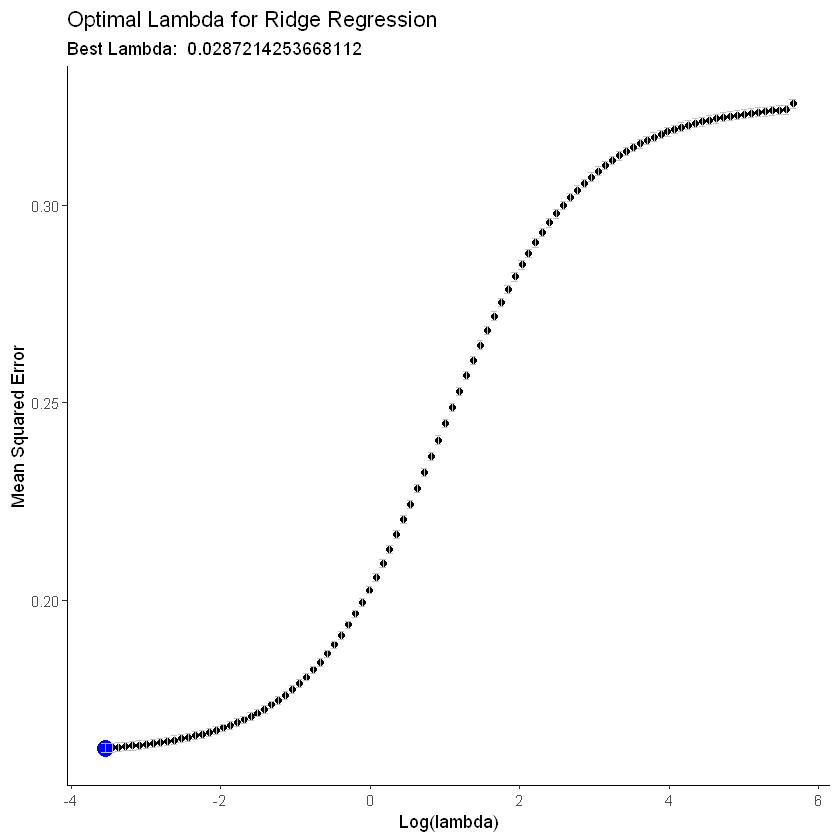

jpeg 
   3

png 
  2

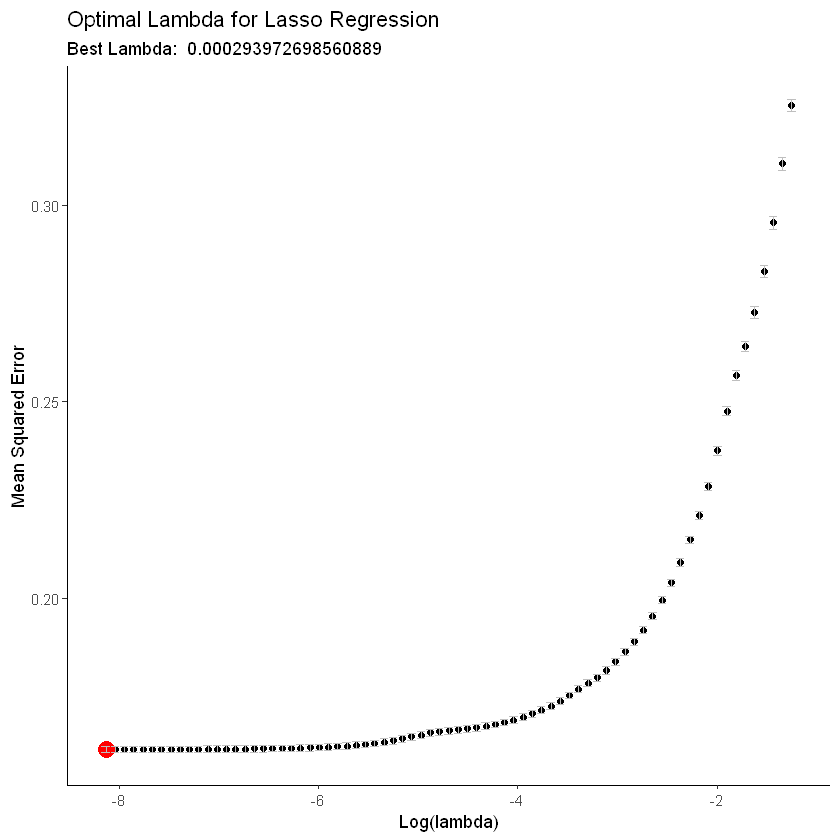

In [187]:
ggplot(mapping = aes(x=log(cv.ridge.out$lambda), y=cv.ridge.out$cvm)) +
  geom_point() +
  geom_point(aes(x=log(bestlam.ridge), y=mse.min.ridge, color="blue", size = 2), show.legend = FALSE, color="blue") +
  geom_errorbar(aes(ymin=cv.ridge.out$cvm-cv.ridge.out$cvsd, ymax=cv.ridge.out$cvm+cv.ridge.out$cvsd), color="gray") +
  xlab("Log(lambda)") +
  ylab("Mean Squared Error") +
  labs(title = "Optimal Lambda for Ridge Regression", subtitle = paste("Best Lambda: ", bestlam.ridge)) +
  theme_classic()
dev.copy(jpeg, filename="Ridge_Lambda.jpg");
dev.off ()


ggplot(mapping = aes(x=log(cv.lasso.out$lambda), y=cv.lasso.out$cvm)) +
  geom_point() +
  geom_point(aes(x=log(bestlam.lasso), y=mse.min.lasso, size = 2), show.legend = FALSE, color="red") +
  geom_errorbar(aes(ymin=cv.lasso.out$cvm-cv.lasso.out$cvsd, ymax=cv.lasso.out$cvm+cv.lasso.out$cvsd), color="gray") +
  xlab("Log(lambda)") +
  ylab("Mean Squared Error") +
  labs(title = "Optimal Lambda for Lasso Regression", subtitle = paste("Best Lambda: ", bestlam.lasso)) +
  theme_classic()
dev.copy(jpeg, filename="Lasso_Lambda.jpg");
dev.off ()

In [188]:
# ridge.coef <- rownames_to_column(data.frame(coef(ridge.model)[,1]), var = "Variable") %>%
#   rename(Coefficient = coef.ridge.model....1.)

# ridge.coef <- ridge.coef %>%
#   filter(Variable != "(Intercept)") %>%
#   arrange(desc(abs(Coefficient)))
# lasso.coef <- rownames_to_column(data.frame(coef(lasso.model)[,1]), var = "Variable") %>%
#   rename(Coefficient = coef.lasso.model....1.)

# lasso.coef <- lasso.coef %>%
#   filter(Variable != "(Intercept)") %>%
#   arrange(desc(abs(Coefficient)))

# coef.compare <- lasso.coef %>%
#   left_join(ridge.coef, by = "Variable") %>%
#   rename("Lasso Coefficient" = Coefficient.x) %>%
#   rename("Ridge Coefficient" = Coefficient.y)

# coef.compare

# write.csv(coef.compare,"../04_Modeling/Ridge_Lasso_Lambda", row.names = FALSE)

ERROR: Error in rename(., Coefficient = coef.ridge.model....1.): unused argument (Coefficient = coef.ridge.model....1.)



Regression tree:
tree(formula = totalinsurancepremiumofthepolicy_log ~ ., data = train)
Variables actually used in tree construction:
[1] "federalpolicyfee"                    
[2] "floodzone_highrisk"                  
[3] "totalbuildinginsurancecoverage_trans"
[4] "elevationdifference_trans"           
Number of terminal nodes:  11 
Residual mean deviance:  0.0693 = 14250 / 205600 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-5.87300 -0.05636 -0.01840  0.00000  0.07237  2.36000 

jpeg 
   3

png 
  2

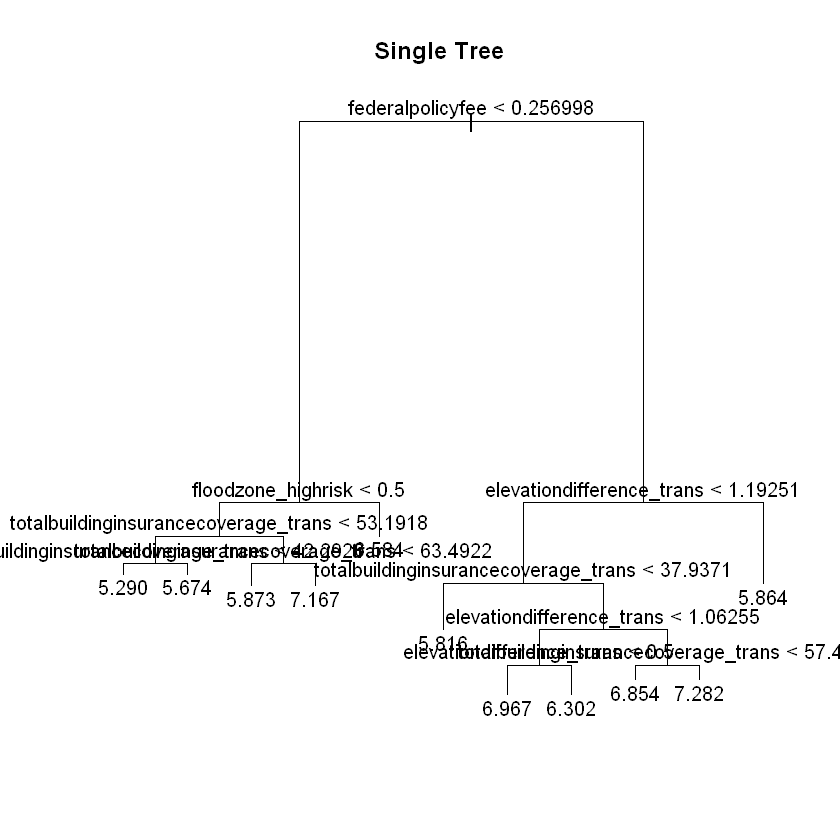

In [189]:
#1.REGRESIION TREE : 

tree.model1 <- tree(totalinsurancepremiumofthepolicy_log ~., data = train)
summary(tree.model1)

plot(tree.model1)
text(tree.model1)
title('Single Tree ')
dev.copy(jpeg, filename = "Single tree_Simple.jpg")
dev.off ()

In [190]:
tree.model <- rpart(totalinsurancepremiumofthepolicy_log ~ federalpolicyfee +floodzone_highrisk + totalbuildinginsurancecoverage_trans + elevationdifference_trans, data = train, method = "anova")
summary(tree.model)

Call:
rpart(formula = totalinsurancepremiumofthepolicy_log ~ federalpolicyfee + 
    floodzone_highrisk + totalbuildinginsurancecoverage_trans + 
    elevationdifference_trans, data = train, method = "anova")
  n= 205655 

           CP nsplit rel error    xerror        xstd
1  0.44117137      0 1.0000000 1.0000053 0.004127412
2  0.09353242      1 0.5588286 0.5588378 0.003370597
3  0.05331217      2 0.4652962 0.4653061 0.003203911
4  0.04093754      3 0.4119840 0.4120107 0.002828465
5  0.03838687      4 0.3710465 0.3710784 0.002779671
6  0.03389629      5 0.3326596 0.3327021 0.002552164
7  0.03214416      6 0.2987633 0.2988047 0.002527060
8  0.02536950      7 0.2666192 0.2666634 0.002426155
9  0.01663437      8 0.2412497 0.2413541 0.002087266
10 0.01179127      9 0.2246153 0.2250794 0.002085191
11 0.01000000     10 0.2128240 0.2132958 0.002118463

Variable importance
                    federalpolicyfee                   floodzone_highrisk 
                                  35         

jpeg 
   3

png 
  2

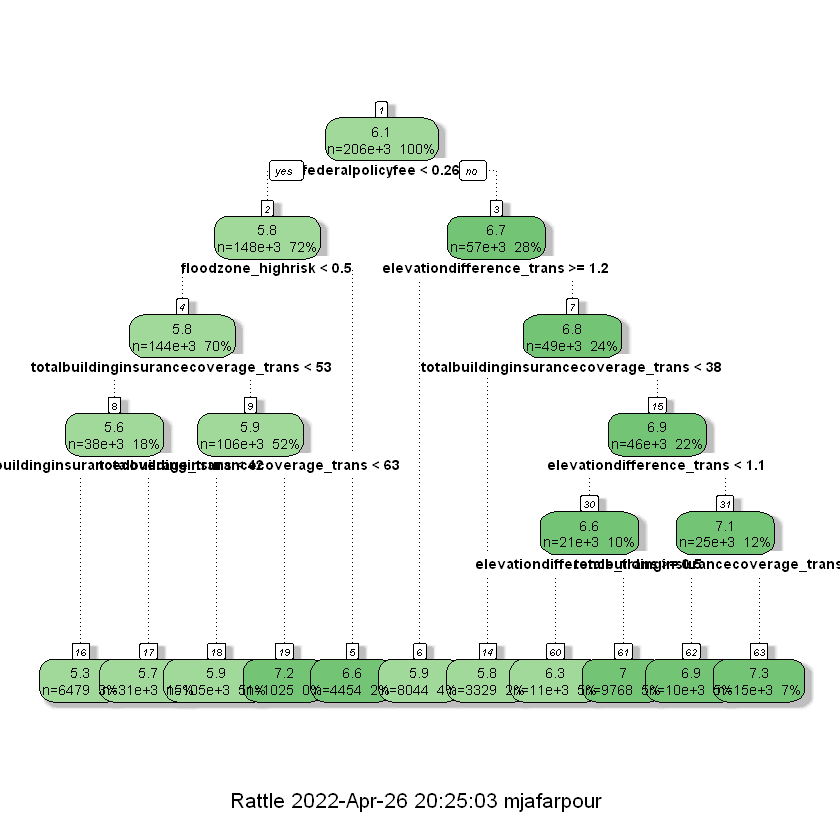

In [191]:

fancyRpartPlot(tree.model, cex = 0.7)		

dev.copy(jpeg, filename = "Regression Tree.jpg")
dev.off ()

In [192]:
pred.tree.train <- predict(tree.model, train)

r2.tree.train <- R_2(pred.tree.train)

tree.pred.test <- predict(tree.model, test)

r2.tree.test <- R_2(tree.pred.test)
print(r2.tree.test)

[1] 0.7841499


[1] 0.8813691


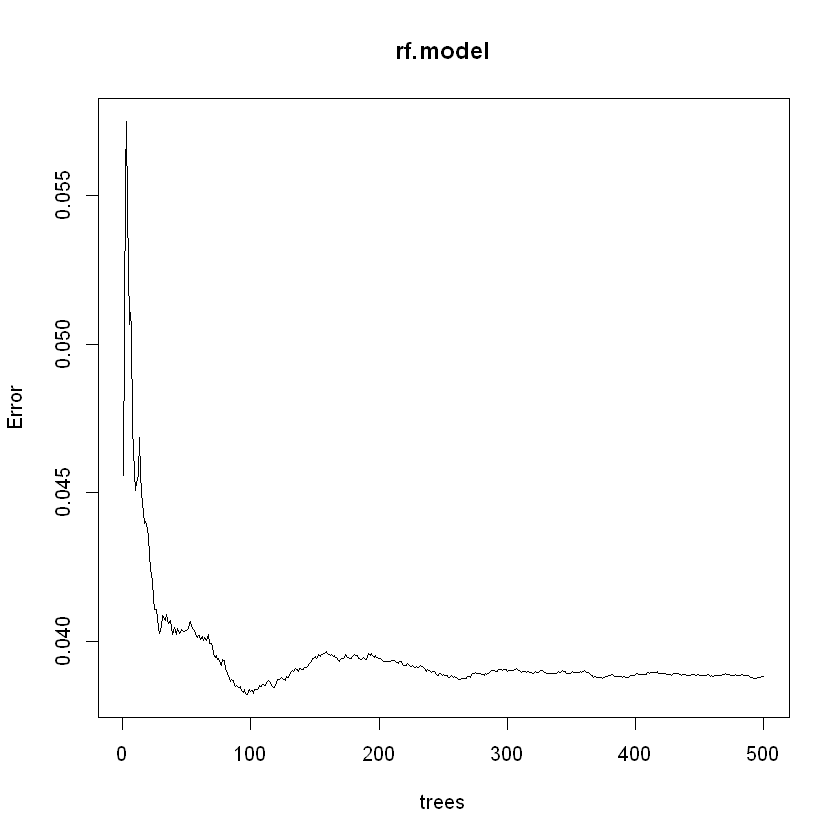

In [193]:
#2. Random Forest (computationally demanding)
rf.model <- randomForest(totalinsurancepremiumofthepolicy_log ~., data = train, mtry = 3, importance = TRUE)
plot(rf.model)

pred.rf.train <- predict(rf.model, train)

r2.rf.train <- R_2(pred.rf.train)

rf.pred.test <- predict(rf.model, test)

r2.rf.test <- R_2(rf.pred.test)

print(r2.rf.test)

jpeg 
   3

png 
  2

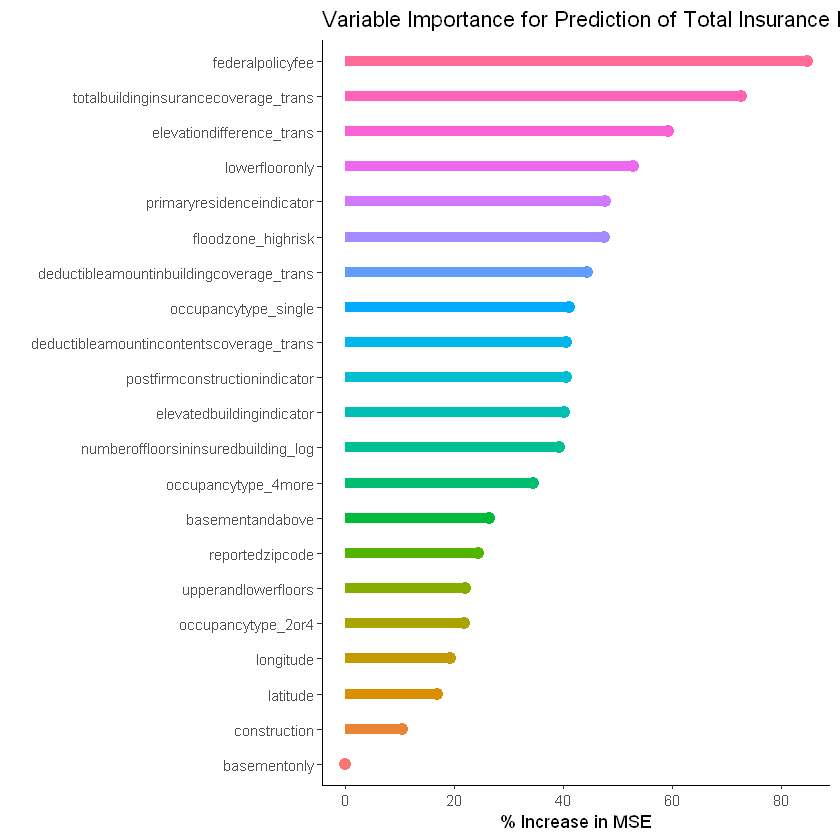

In [194]:
imp <- data.frame(importance(rf.model, type = 1))
imp <- rownames_to_column(imp, var = "variable")

ggplot(imp, aes(x = reorder(variable, X.IncMSE), y = X.IncMSE, color = reorder(variable, X.IncMSE))) +
  geom_point(show.legend=FALSE, size=3) +
  geom_segment(aes(x=variable, xend=variable, y=0, yend = X.IncMSE), size = 3, show.legend=FALSE) +
  xlab("") +
  ylab("% Increase in MSE") +
  labs(title = "Variable Importance for Prediction of Total Insurance Premium") +
  coord_flip() +
  theme_classic()

dev.copy(jpeg, filename = "Random Forest.jpg")
dev.off ()

jpeg 
   3

png 
  2

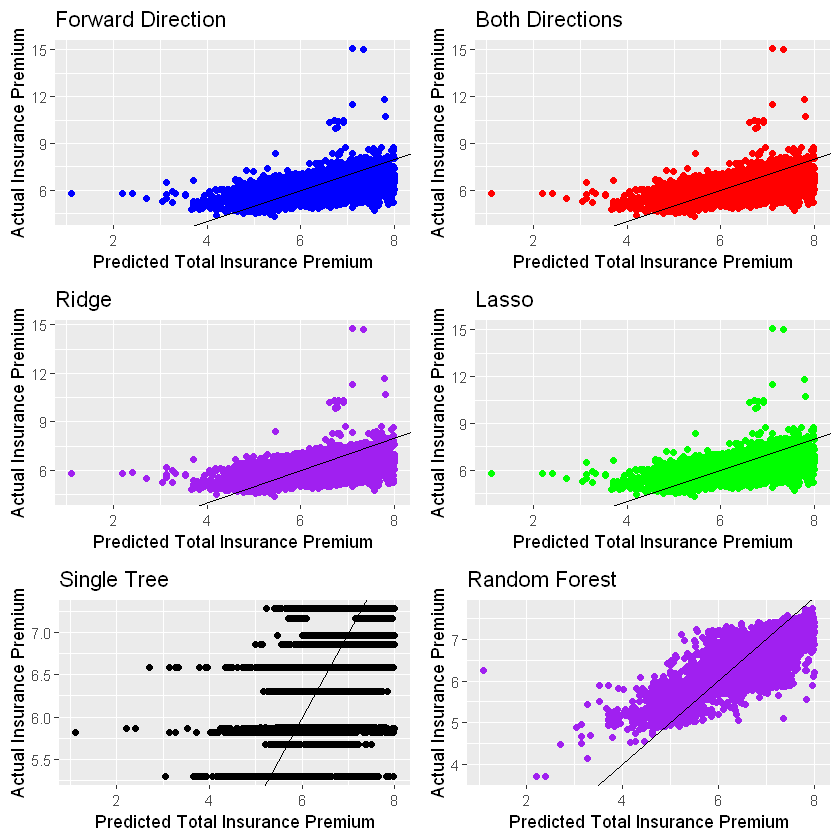

In [195]:
# PLOT ALL THE MODELS

p1 <- ggplot(mapping = aes(x = test$totalinsurancepremiumofthepolicy_log, y = fwd.pred.test)) +
  geom_point(color = "blue") +
  geom_abline(slope = 1) +
  xlab("Predicted Total Insurance Premium") +
  ylab("Actual Insurance Premium") +
  labs(title = "Forward Direction")

p2 <- ggplot(mapping = aes(x = test$totalinsurancepremiumofthepolicy_log, y = both.pred.test)) +
  geom_point(color = "red") +
  geom_abline(slope = 1) +
  xlab("Predicted Total Insurance Premium") +
  ylab("Actual Insurance Premium") +
  labs(title = "Both Directions")

p3 <- ggplot(mapping = aes(x = test$totalinsurancepremiumofthepolicy_log, y = ridge.pred.test)) +
  geom_point(color = "purple") +
  geom_abline(slope = 1) +
  xlab("Predicted Total Insurance Premium") +
  ylab("Actual Insurance Premium") +
  labs(title = "Ridge")

p4 <- ggplot(mapping = aes(x = test$totalinsurancepremiumofthepolicy_log, y = lasso.pred.test)) +
  geom_point(color = "green") +
  geom_abline(slope = 1) +
  xlab("Predicted Total Insurance Premium") +
  ylab("Actual Insurance Premium") +
  labs(title = "Lasso")

p5 <- ggplot(mapping = aes(x = test$totalinsurancepremiumofthepolicy_log, y = tree.pred.test)) +
  geom_point(color = "black") +
  geom_abline(slope = 1) +
  xlab("Predicted Total Insurance Premium") +
  ylab("Actual Insurance Premium") +
  labs(title = "Single Tree")

p6 <- ggplot(mapping = aes(x = test$totalinsurancepremiumofthepolicy_log, y = rf.pred.test)) +
  geom_point(color = "purple") +
  geom_abline(slope = 1) +
  xlab("Predicted Total Insurance Premium") +
  ylab("Actual Insurance Premium") +
  labs(title = "Random Forest")

grid.arrange(p1, p2, p3, p4, p5, p6, nrow = 3)

dev.copy(jpeg, filename = "All Plots.jpg")
dev.off ()